# Load Important Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
from sklearn import  metrics
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from xgboost import plot_importance

import joblib

from hyperopt.pyll.stochastic import sample
from hyperopt import tpe, Trials, hp, STATUS_OK, fmin
from timeit import default_timer as timer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

/root/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Utility Functions

In [2]:
# Function to calculate performance table with f1_macro score and acculacy
def perf_measure(y_actual, y_pred):
    eval_dict = {}
    cm = metrics.confusion_matrix(y_actual, y_pred)
    TN = cm[0][0]
    TP = cm[1][1]
    FN = cm[1][0]
    FP = cm[0][1]
    eval_dict['F1_Score'] = [
        metrics.f1_score(y_actual, y_pred, average='macro')
    ]
    eval_dict['Accuracy'] = [
        metrics.accuracy_score(y_actual, y_pred)
    ]
    eval_dict['Class_Count'] = [len(y_actual)/100, len([i for i in y_actual if i in [0, 'clean']])/100, 
                                len([i for i in y_actual if i in [1,'malicious']])/100]
    eval_dict['Class_Ratio'] = [i/len(y_actual) for i in eval_dict['Class_Count']]
    return pd.DataFrame(eval_dict, index=['Overall', 0, 1]) * 100

# Function to calculate performance table for various thresholds
def score_df(df, target, preds, cutOffList):
    temp = pd.DataFrame(
    pd.concat([                                               
        perf_measure(
            target,
            df[preds].apply(lambda x: 1 if x >= i else 0)).loc[['Overall'
                                                                    ]]
        for i in cutOffList
    ],
              ignore_index=True))
    temp.index = ['@_'+str(i) for i in cutOffList]
    display(temp)

In [3]:
# Function to calculate the feature importance for LGBM model

def get_lgbm_varimp_gain(model, train_columns, max_vars=50):
    
    if "basic.Booster" in str(model.__class__):
        # lightgbm.basic.Booster was trained directly, so using feature_importance() function 
        cv_varimp_df = pd.DataFrame([train_columns, model.feature_importance(importance_type='gain')]).T
    else:
        # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted, 
        # so using feature_importances_ property
        cv_varimp_df = pd.DataFrame([train_columns, model.booster_.feature_importance(importance_type='gain')]).T

    cv_varimp_df.columns = ['feature_name', 'varimp']

    cv_varimp_df.sort_values(by='varimp', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   

    return cv_varimp_df



# Prediction on Test Data

In [4]:
# Load Machine Learning Models
xgb=joblib.load("xgb_model")
lgb=joblib.load("lgb_model")

In [5]:
# Load Data
test = pd.read_csv("test_lTY72QC.csv")

In [6]:
# Create Features
Income_dict = {'Less than 5L':1, '5L - 10L':2, '10L - 15L':3, 'More than 15L':4}

test['Gender_num'] = test['Gender'].apply(lambda row: 1 if row=='Male' else 0)
test['Income_num'] = test['Income'].apply(lambda row: Income_dict[row] if row in Income_dict.keys() else 0)
test['Product_Holdings_1'] = test['Product_Holdings'].apply(lambda row: 1 if row=='1' else 0)
test['Product_Holdings_2'] = test['Product_Holdings'].apply(lambda row: 1 if row=='2' else 0)
test['Product_Holdings_3_plus'] = test['Product_Holdings'].apply(lambda row: 1 if row=='3+' else 0)
test['Credit_Category_Good'] = test['Credit_Category'].apply(lambda row: 1 if row=='Good' else 0)
test['Credit_Category_Poor'] = test['Credit_Category'].apply(lambda row: 1 if row=='Poor' else 0)
test['Credit_Category_Average'] = test['Credit_Category'].apply(lambda row: 1 if row=='Average' else 0)

test['Income_Age_ratio'] = test.apply(lambda x: x.Income_num/x.Age if x.Age!=0 else 0, axis=1)
test['Vintage_Age_ratio'] = test.apply(lambda x: x.Vintage/x.Age if x.Age!=0 else 0, axis=1)
test['Balance_Income_ratio'] = test.apply(lambda x: x.Balance/x.Income_num if x.Income_num!=0 else 0, axis=1)
test['Balance_Age_ratio'] = test.apply(lambda x: x.Balance/x.Age if x.Age!=0 else 0, axis=1)
test['Vintage_Balance_ratio'] = test.apply(lambda x: x.Vintage/x.Balance if x.Balance!=0 else 0, axis=1)
test['Vintage_Income_ratio'] = test.apply(lambda x: x.Vintage/x.Income_num if x.Income_num!=0 else 0, axis=1)

test['Income_squared'] = test['Income_num'].apply(lambda row: pow(row, 2))
test['Vintage_squared'] = test['Vintage'].apply(lambda row: pow(row, 2))

test['Product_Holdings_num'] = test['Product_Holdings'].apply(lambda row: 1 if row=='1' else 2 if row=='2' else 3
                                                                if row=='3+' else 0)
test['Age_Product_Holdings_ratio'] = test.apply(lambda x: x.Age/x.Product_Holdings_num 
                                                  if x.Product_Holdings_num!=0 else 0, axis=1)
test['Income_Product_Holdings_ratio'] = test.apply(lambda x: x.Income_num/x.Product_Holdings_num 
                                                     if x.Product_Holdings_num!=0 else 0, axis=1)
test['Balance_Product_Holdings_ratio'] = test.apply(lambda x: x.Balance/x.Product_Holdings_num 
                                                      if x.Product_Holdings_num!=0 else 0, axis=1)
test['Vintage_Product_Holdings_ratio'] = test.apply(lambda x: x.Vintage/x.Product_Holdings_num 
                                                      if x.Product_Holdings_num!=0 else 0, axis=1)
test['Product_Holdings_squared'] = test['Product_Holdings_num'].apply(lambda row: pow(row, 2))

test['Income_squared_Age_ratio'] = test.apply(lambda x: x.Income_squared/x.Age if x.Age!=0 else 0, axis=1)
test['Vintage_squared_Age_ratio'] = test.apply(lambda x: x.Vintage_squared/x.Age if x.Age!=0 else 0, axis=1)
test['Balance_Income_squared_ratio'] = test.apply(lambda x: x.Balance/x.Income_squared if x.Income_squared!=0 else 0, 
                                                    axis=1)
test['Vintage_squared_Balance_ratio'] = test.apply(lambda x: x.Vintage_squared/x.Balance if x.Balance!=0 else 0, axis=1)
test['Vintage_Income_squared_ratio'] = test.apply(lambda x: x.Vintage/x.Income_squared if x.Income_squared!=0 else 0, 
                                                    axis=1)
test['Vintage_squared_Income_ratio'] = test.apply(lambda x: x.Vintage_squared/x.Income_num if x.Income_squared!=0 
                                                    else 0,  axis=1)
test['Vintage_squared_Income_squared_ratio'] = test.apply(lambda x: x.Vintage_squared/x.Income_squared 
                                                            if x.Income_squared!=0 else 0,  axis=1)


test['Age_Product_Holdings_squared_ratio'] = test.apply(lambda x: x.Age/x.Product_Holdings_squared 
                                                  if x.Product_Holdings_squared!=0 else 0, axis=1)
test['Balance_Product_Holdings_squared_ratio'] = test.apply(lambda x: x.Balance/x.Product_Holdings_squared 
                                                      if x.Product_Holdings_squared!=0 else 0, axis=1)
test['Income_Product_Holdings_squared_ratio'] = test.apply(lambda x: x.Income_num/x.Product_Holdings_squared 
                                                     if x.Product_Holdings_squared!=0 else 0, axis=1)
test['Income_squared_Product_Holdings_ratio'] = test.apply(lambda x: x.Income_squared/x.Product_Holdings_num
                                                     if x.Product_Holdings_num!=0 else 0, axis=1)
test['Income_squared_Product_Holdings_squared_ratio'] = test.apply(lambda x: x.Income_squared
                                                                     /x.Product_Holdings_squared 
                                                     if x.Product_Holdings_squared!=0 else 0, axis=1)
test['Vintage_Product_Holdings_squared_ratio'] = test.apply(lambda x: x.Vintage/x.Product_Holdings_squared 
                                                      if x.Product_Holdings_squared!=0 else 0, axis=1)
test['Vintage_squared_Product_Holdings_ratio'] = test.apply(lambda x: x.Vintage_squared/x.Product_Holdings_num
                                                      if x.Product_Holdings_num!=0 else 0, axis=1)
test['Vintage_squared_Product_Holdings_squared_ratio'] = test.apply(lambda x: x.Vintage_squared
                                                                      /x.Product_Holdings_squared 
                                                      if x.Product_Holdings_squared!=0 else 0, axis=1)

In [7]:
features1=['Age', 'Balance', 'Vintage', 'Transaction_Status', 'Credit_Card', 'Gender_num', 'Income_num', 
           'Product_Holdings_1', 'Credit_Category_Good', 'Credit_Category_Poor', 'Credit_Category_Average', 
           'Income_Age_ratio', 'Balance_Income_ratio', 'Vintage_Balance_ratio', 'Vintage_Income_ratio', 
           'Age_Product_Holdings_ratio', 'Income_Product_Holdings_ratio', 'Balance_Product_Holdings_ratio', 
           'Vintage_Product_Holdings_ratio']

In [8]:
# Calculate predicted probabilities
test['xgb_preds'] = xgb.predict_proba(test[features1])[:, 1]
test['lgb_preds'] = lgb.predict_proba(test[features1])[:, 1]

# Apply weighted ensembling
test['xgb_lgb'] = 0.4*test['xgb_preds'] + 0.6*test['lgb_preds']

# Calculate churn with optimal threshold (0.42 here)
test['Is_Churn'] = test['xgb_lgb'].apply(lambda x: 1 if x>0.42 else 0)

In [9]:
# Save the output file with ID and churn prediction (Is_Churn) columns
test[['ID', 'Is_Churn']].to_csv("output_xgb_lgb_4_6__19vars_0.42.csv", index = False)

# Training

## Data Preprocessing

### Load Train Data and verify related informations, distribution of target (Is_Churn) column, etc.

In [10]:
# load data
train = pd.read_csv("train_PDjVQMB.csv")

# Data Info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  6650 non-null   object 
 1   Age                 6650 non-null   int64  
 2   Gender              6650 non-null   object 
 3   Income              6650 non-null   object 
 4   Balance             6650 non-null   float64
 5   Vintage             6650 non-null   int64  
 6   Transaction_Status  6650 non-null   int64  
 7   Product_Holdings    6650 non-null   object 
 8   Credit_Card         6650 non-null   int64  
 9   Credit_Category     6650 non-null   object 
 10  Is_Churn            6650 non-null   int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 571.6+ KB


In [11]:
# check if any duplicate ID
len(train['ID'].unique())

6650

In [12]:
# first 5 rows of the data
train.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,84e2fcc9,36,Female,5L - 10L,563266.44,4,0,1,0,Average,1
1,57fea15e,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,0
2,8df34ef3,35,Female,More than 15L,701607.06,2,1,2,0,Poor,0
3,c5c0788b,43,Female,More than 15L,1393922.16,0,1,2,1,Poor,1
4,951d69c4,39,Female,More than 15L,893146.23,1,1,1,1,Good,1


In [13]:
# check if any null values are there
train.isnull().sum()

ID                    0
Age                   0
Gender                0
Income                0
Balance               0
Vintage               0
Transaction_Status    0
Product_Holdings      0
Credit_Card           0
Credit_Category       0
Is_Churn              0
dtype: int64

In [14]:
# check the data types of each column
train.dtypes

ID                     object
Age                     int64
Gender                 object
Income                 object
Balance               float64
Vintage                 int64
Transaction_Status      int64
Product_Holdings       object
Credit_Card             int64
Credit_Category        object
Is_Churn                int64
dtype: object

In [15]:
# verify the distribution of target column (Is_Churn)

# count distribution
print('count distribution')
print(train['Is_Churn'].value_counts())
print('\n')

# proportion distribution
print('proportion distribution')
print(train['Is_Churn'].value_counts(1))

count distribution
0    5113
1    1537
Name: Is_Churn, dtype: int64


proportion distribution
0    0.768872
1    0.231128
Name: Is_Churn, dtype: float64


### Univariate analysis for each feature except ID

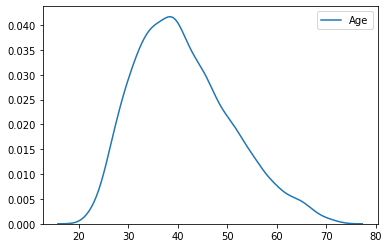

In [16]:
sns.kdeplot(train["Age"])

In [17]:
print(train['Gender'].value_counts())
print(train['Gender'].value_counts(1))

Male      3612
Female    3038
Name: Gender, dtype: int64
Male      0.543158
Female    0.456842
Name: Gender, dtype: float64


In [18]:
print(train['Income'].value_counts())
print(train['Income'].value_counts(1))

10L - 15L        1885
5L - 10L         1847
Less than 5L     1573
More than 15L    1345
Name: Income, dtype: int64
10L - 15L        0.283459
5L - 10L         0.277744
Less than 5L     0.236541
More than 15L    0.202256
Name: Income, dtype: float64


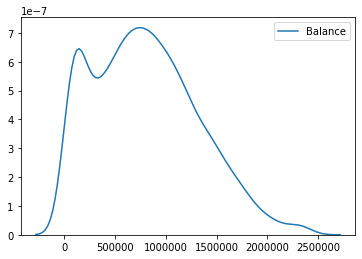

In [19]:
sns.kdeplot(train["Balance"])

In [20]:
print(train['Vintage'].value_counts())
print(train['Vintage'].value_counts(1))

3    1405
1    1354
2    1328
4    1296
0     956
5     311
Name: Vintage, dtype: int64
3    0.211278
1    0.203609
2    0.199699
4    0.194887
0    0.143759
5    0.046767
Name: Vintage, dtype: float64


In [21]:
print(train['Transaction_Status'].value_counts())
print(train['Transaction_Status'].value_counts(1))

1    3430
0    3220
Name: Transaction_Status, dtype: int64
1    0.515789
0    0.484211
Name: Transaction_Status, dtype: float64


In [22]:
print(train['Product_Holdings'].value_counts())
print(train['Product_Holdings'].value_counts(1))

1     3200
2     3182
3+     268
Name: Product_Holdings, dtype: int64
1     0.481203
2     0.478496
3+    0.040301
Name: Product_Holdings, dtype: float64


In [23]:
print(train['Credit_Card'].value_counts())
print(train['Credit_Card'].value_counts(1))

1    4418
0    2232
Name: Credit_Card, dtype: int64
1    0.664361
0    0.335639
Name: Credit_Card, dtype: float64


In [24]:
print(train['Credit_Category'].value_counts())
print(train['Credit_Category'].value_counts(1))

Poor       3076
Average    2043
Good       1531
Name: Credit_Category, dtype: int64
Poor       0.462556
Average    0.307218
Good       0.230226
Name: Credit_Category, dtype: float64


### Bi-variate analysis for each feature except ID, with respect to target column (Is_Churn)

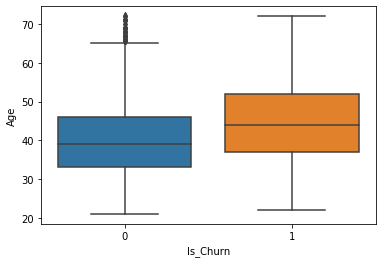

In [25]:
sns.boxplot(train['Is_Churn'], train['Age'])

In [26]:
pd.crosstab(train['Is_Churn'], train['Gender'])

Gender,Female,Male
Is_Churn,,
0,2261,2852
1,777,760


In [27]:
pd.crosstab(train['Is_Churn'], train['Income'])

Income,10L - 15L,5L - 10L,Less than 5L,More than 15L
Is_Churn,,,,
0,1441,1435,1219,1018
1,444,412,354,327


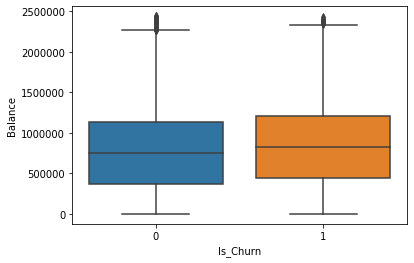

In [28]:
sns.boxplot(train['Is_Churn'], train['Balance'])

In [29]:
pd.crosstab(train['Is_Churn'], train['Vintage'])

Vintage,0,1,2,3,4,5
Is_Churn,,,,,,
0,755,1026,1052,1066,975,239
1,201,328,276,339,321,72


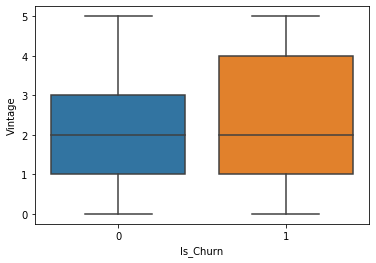

In [30]:
sns.boxplot(train['Is_Churn'], train['Vintage'])

In [31]:
pd.crosstab(train['Is_Churn'], train['Transaction_Status'])

Transaction_Status,0,1
Is_Churn,,
0,2354,2759
1,866,671


In [32]:
pd.crosstab(train['Is_Churn'], train['Product_Holdings'])

Product_Holdings,1,2,3+
Is_Churn,,,
0,2414,2490,209
1,786,692,59


In [33]:
pd.crosstab(train['Is_Churn'], train['Credit_Card'])

Credit_Card,0,1
Is_Churn,,
0,1715,3398
1,517,1020


In [34]:
pd.crosstab(train['Is_Churn'], train['Credit_Category'])

Credit_Category,Average,Good,Poor
Is_Churn,,,
0,1572,1220,2321
1,471,311,755


## Feature Engineering

### Create new features

In [35]:
Income_dict = {'Less than 5L':1, '5L - 10L':2, '10L - 15L':3, 'More than 15L':4}

In [36]:
train['Gender_num'] = train['Gender'].apply(lambda row: 1 if row=='Male' else 0)
train['Income_num'] = train['Income'].apply(lambda row: Income_dict[row] if row in Income_dict.keys() else 0)
train['Product_Holdings_1'] = train['Product_Holdings'].apply(lambda row: 1 if row=='1' else 0)
train['Product_Holdings_2'] = train['Product_Holdings'].apply(lambda row: 1 if row=='2' else 0)
train['Product_Holdings_3_plus'] = train['Product_Holdings'].apply(lambda row: 1 if row=='3+' else 0)
train['Credit_Category_Good'] = train['Credit_Category'].apply(lambda row: 1 if row=='Good' else 0)
train['Credit_Category_Poor'] = train['Credit_Category'].apply(lambda row: 1 if row=='Poor' else 0)
train['Credit_Category_Average'] = train['Credit_Category'].apply(lambda row: 1 if row=='Average' else 0)

train['Income_Age_ratio'] = train.apply(lambda x: x.Income_num/x.Age if x.Age!=0 else 0, axis=1)
train['Vintage_Age_ratio'] = train.apply(lambda x: x.Vintage/x.Age if x.Age!=0 else 0, axis=1)
train['Balance_Income_ratio'] = train.apply(lambda x: x.Balance/x.Income_num if x.Income_num!=0 else 0, axis=1)
train['Balance_Age_ratio'] = train.apply(lambda x: x.Balance/x.Age if x.Age!=0 else 0, axis=1)
train['Vintage_Balance_ratio'] = train.apply(lambda x: x.Vintage/x.Balance if x.Balance!=0 else 0, axis=1)
train['Vintage_Income_ratio'] = train.apply(lambda x: x.Vintage/x.Income_num if x.Income_num!=0 else 0, axis=1)

train['Income_squared'] = train['Income_num'].apply(lambda row: pow(row, 2))
train['Vintage_squared'] = train['Vintage'].apply(lambda row: pow(row, 2))

train['Product_Holdings_num'] = train['Product_Holdings'].apply(lambda row: 1 if row=='1' else 2 if row=='2' else 3
                                                                if row=='3+' else 0)
train['Age_Product_Holdings_ratio'] = train.apply(lambda x: x.Age/x.Product_Holdings_num 
                                                  if x.Product_Holdings_num!=0 else 0, axis=1)
train['Income_Product_Holdings_ratio'] = train.apply(lambda x: x.Income_num/x.Product_Holdings_num 
                                                     if x.Product_Holdings_num!=0 else 0, axis=1)
train['Balance_Product_Holdings_ratio'] = train.apply(lambda x: x.Balance/x.Product_Holdings_num 
                                                      if x.Product_Holdings_num!=0 else 0, axis=1)
train['Vintage_Product_Holdings_ratio'] = train.apply(lambda x: x.Vintage/x.Product_Holdings_num 
                                                      if x.Product_Holdings_num!=0 else 0, axis=1)
train['Product_Holdings_squared'] = train['Product_Holdings_num'].apply(lambda row: pow(row, 2))

train['Income_squared_Age_ratio'] = train.apply(lambda x: x.Income_squared/x.Age if x.Age!=0 else 0, axis=1)
train['Vintage_squared_Age_ratio'] = train.apply(lambda x: x.Vintage_squared/x.Age if x.Age!=0 else 0, axis=1)
train['Balance_Income_squared_ratio'] = train.apply(lambda x: x.Balance/x.Income_squared if x.Income_squared!=0 else 0, 
                                                    axis=1)
train['Vintage_squared_Balance_ratio'] = train.apply(lambda x: x.Vintage_squared/x.Balance if x.Balance!=0 else 0, axis=1)
train['Vintage_Income_squared_ratio'] = train.apply(lambda x: x.Vintage/x.Income_squared if x.Income_squared!=0 else 0, 
                                                    axis=1)
train['Vintage_squared_Income_ratio'] = train.apply(lambda x: x.Vintage_squared/x.Income_num if x.Income_squared!=0 
                                                    else 0,  axis=1)
train['Vintage_squared_Income_squared_ratio'] = train.apply(lambda x: x.Vintage_squared/x.Income_squared 
                                                            if x.Income_squared!=0 else 0,  axis=1)


train['Age_Product_Holdings_squared_ratio'] = train.apply(lambda x: x.Age/x.Product_Holdings_squared 
                                                  if x.Product_Holdings_squared!=0 else 0, axis=1)
train['Balance_Product_Holdings_squared_ratio'] = train.apply(lambda x: x.Balance/x.Product_Holdings_squared 
                                                      if x.Product_Holdings_squared!=0 else 0, axis=1)
train['Income_Product_Holdings_squared_ratio'] = train.apply(lambda x: x.Income_num/x.Product_Holdings_squared 
                                                     if x.Product_Holdings_squared!=0 else 0, axis=1)
train['Income_squared_Product_Holdings_ratio'] = train.apply(lambda x: x.Income_squared/x.Product_Holdings_num
                                                     if x.Product_Holdings_num!=0 else 0, axis=1)
train['Income_squared_Product_Holdings_squared_ratio'] = train.apply(lambda x: x.Income_squared
                                                                     /x.Product_Holdings_squared 
                                                     if x.Product_Holdings_squared!=0 else 0, axis=1)
train['Vintage_Product_Holdings_squared_ratio'] = train.apply(lambda x: x.Vintage/x.Product_Holdings_squared 
                                                      if x.Product_Holdings_squared!=0 else 0, axis=1)
train['Vintage_squared_Product_Holdings_ratio'] = train.apply(lambda x: x.Vintage_squared/x.Product_Holdings_num
                                                      if x.Product_Holdings_num!=0 else 0, axis=1)
train['Vintage_squared_Product_Holdings_squared_ratio'] = train.apply(lambda x: x.Vintage_squared
                                                                      /x.Product_Holdings_squared 
                                                      if x.Product_Holdings_squared!=0 else 0, axis=1)

### Verifying details and descriptions of new features

In [37]:
train.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,...,Vintage_squared_Income_ratio,Vintage_squared_Income_squared_ratio,Age_Product_Holdings_squared_ratio,Balance_Product_Holdings_squared_ratio,Income_Product_Holdings_squared_ratio,Income_squared_Product_Holdings_ratio,Income_squared_Product_Holdings_squared_ratio,Vintage_Product_Holdings_squared_ratio,Vintage_squared_Product_Holdings_ratio,Vintage_squared_Product_Holdings_squared_ratio
0,84e2fcc9,36,Female,5L - 10L,563266.44,4,0,1,0,Average,...,8.00,4.0000,36.00,563266.440,2.0,4.0,4.0,4.0,16.0,16.0
1,57fea15e,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,...,4.00,4.0000,53.00,875572.110,1.0,1.0,1.0,2.0,4.0,4.0
2,8df34ef3,35,Female,More than 15L,701607.06,2,1,2,0,Poor,...,1.00,0.2500,8.75,175401.765,1.0,8.0,4.0,0.5,2.0,1.0
3,c5c0788b,43,Female,More than 15L,1393922.16,0,1,2,1,Poor,...,0.00,0.0000,10.75,348480.540,1.0,8.0,4.0,0.0,0.0,0.0
4,951d69c4,39,Female,More than 15L,893146.23,1,1,1,1,Good,...,0.25,0.0625,39.00,893146.230,4.0,16.0,16.0,1.0,1.0,1.0


In [38]:
feature_list = ['Age', 'Balance', 'Vintage', 'Transaction_Status', 'Credit_Card', 'Gender_num', 'Income_num', 
                'Product_Holdings_1', 'Product_Holdings_2', 'Product_Holdings_3_plus', 'Credit_Category_Good', 
                'Credit_Category_Poor', 'Credit_Category_Average', 'Income_Age_ratio', 'Vintage_Age_ratio', 
                'Balance_Income_ratio', 'Balance_Age_ratio', 'Vintage_Balance_ratio', 'Vintage_Income_ratio', 
                'Income_squared', 'Vintage_squared', 'Product_Holdings_num', 'Age_Product_Holdings_ratio', 
                'Income_Product_Holdings_ratio', 'Balance_Product_Holdings_ratio', 'Vintage_Product_Holdings_ratio', 
                'Product_Holdings_squared', 'Income_squared_Age_ratio', 'Vintage_squared_Age_ratio', 
                'Balance_Income_squared_ratio', 
                'Vintage_squared_Balance_ratio', 'Vintage_Income_squared_ratio', 'Vintage_squared_Income_ratio', 
                'Vintage_squared_Income_squared_ratio', 'Age_Product_Holdings_squared_ratio', 
                'Balance_Product_Holdings_squared_ratio', 
                'Income_Product_Holdings_squared_ratio', 'Income_squared_Product_Holdings_ratio',
                'Income_squared_Product_Holdings_squared_ratio', 'Vintage_Product_Holdings_squared_ratio', 
                'Vintage_squared_Product_Holdings_ratio', 'Vintage_squared_Product_Holdings_squared_ratio']
len(feature_list)

42

In [39]:
[i for i in train.columns if i not in feature_list]

['ID', 'Gender', 'Income', 'Product_Holdings', 'Credit_Category', 'Is_Churn']

In [40]:
with pd.option_context("display.max_columns", None):
    display(train[feature_list].head())

,Age,Balance,Vintage,Transaction_Status,Credit_Card,Gender_num,Income_num,Product_Holdings_1,Product_Holdings_2,Product_Holdings_3_plus,Credit_Category_Good,Credit_Category_Poor,Credit_Category_Average,Income_Age_ratio,Vintage_Age_ratio,Balance_Income_ratio,Balance_Age_ratio,Vintage_Balance_ratio,Vintage_Income_ratio,Income_squared,Vintage_squared,Product_Holdings_num,Age_Product_Holdings_ratio,Income_Product_Holdings_ratio,Balance_Product_Holdings_ratio,Vintage_Product_Holdings_ratio,Product_Holdings_squared,Income_squared_Age_ratio,Vintage_squared_Age_ratio,Balance_Income_squared_ratio,Vintage_squared_Balance_ratio,Vintage_Income_squared_ratio,Vintage_squared_Income_ratio,Vintage_squared_Income_squared_ratio,Age_Product_Holdings_squared_ratio,Balance_Product_Holdings_squared_ratio,Income_Product_Holdings_squared_ratio,Income_squared_Product_Holdings_ratio,Income_squared_Product_Holdings_squared_ratio,Vintage_Product_Holdings_squared_ratio,Vintage_squared_Product_Holdings_ratio,Vintage_squared_Product_Holdings_squared_ratio
0,36,563266.44,4,0,0,0,2,1,0,0,0,0,1,0.055556,0.111111,281633.2200,15646.290000,0.000007,2.00,4,16,1,36.0,2.0,563266.44,4.0,1,0.111111,0.444444,140816.610000,0.000028,1.0000,8.00,4.0000,36.00,563266.440,2.0,4.0,4.0,4.0,16.0,16.0
1,53,875572.11,2,1,1,0,1,1,0,0,0,1,0,0.018868,0.037736,875572.1100,16520.228491,0.000002,2.00,1,4,1,53.0,1.0,875572.11,2.0,1,0.018868,0.075472,875572.110000,0.000005,2.0000,4.00,4.0000,53.00,875572.110,1.0,1.0,1.0,2.0,4.0,4.0
2,35,701607.06,2,1,0,0,4,0,1,0,0,1,0,0.114286,0.057143,175401.7650,20045.916000,0.000003,0.50,16,4,2,17.5,2.0,350803.53,1.0,4,0.457143,0.114286,43850.441250,0.000006,0.1250,1.00,0.2500,8.75,175401.765,1.0,8.0,4.0,0.5,2.0,1.0
3,43,1393922.16,0,1,1,0,4,0,1,0,0,1,0,0.093023,0.000000,348480.5400,32416.794419,0.000000,0.00,16,0,2,21.5,2.0,696961.08,0.0,4,0.372093,0.000000,87120.135000,0.000000,0.0000,0.00,0.0000,10.75,348480.540,1.0,8.0,4.0,0.0,0.0,0.0
4,39,893146.23,1,1,1,0,4,1,0,0,1,0,0,0.102564,0.025641,223286.5575,22901.185385,0.000001,0.25,16,1,1,39.0,4.0,893146.23,1.0,1,0.410256,0.025641,55821.639375,0.000001,0.0625,0.25,0.0625,39.00,893146.230,4.0,16.0,16.0,1.0,1.0,1.0


In [41]:
with pd.option_context("display.max_columns", None):
    display(train[feature_list].describe())

,Age,Balance,Vintage,Transaction_Status,Credit_Card,Gender_num,Income_num,Product_Holdings_1,Product_Holdings_2,Product_Holdings_3_plus,Credit_Category_Good,Credit_Category_Poor,Credit_Category_Average,Income_Age_ratio,Vintage_Age_ratio,Balance_Income_ratio,Balance_Age_ratio,Vintage_Balance_ratio,Vintage_Income_ratio,Income_squared,Vintage_squared,Product_Holdings_num,Age_Product_Holdings_ratio,Income_Product_Holdings_ratio,Balance_Product_Holdings_ratio,Vintage_Product_Holdings_ratio,Product_Holdings_squared,Income_squared_Age_ratio,Vintage_squared_Age_ratio,Balance_Income_squared_ratio,Vintage_squared_Balance_ratio,Vintage_Income_squared_ratio,Vintage_squared_Income_ratio,Vintage_squared_Income_squared_ratio,Age_Product_Holdings_squared_ratio,Balance_Product_Holdings_squared_ratio,Income_Product_Holdings_squared_ratio,Income_squared_Product_Holdings_ratio,Income_squared_Product_Holdings_squared_ratio,Vintage_Product_Holdings_squared_ratio,Vintage_squared_Product_Holdings_ratio,Vintage_squared_Product_Holdings_squared_ratio
count,6650.000000,6.650000e+03,6650.000000,6650.000000,6650.000000,6650.000000,6650.000000,6650.000000,6650.000000,6650.000000,6650.000000,6650.000000,6650.000000,6650.000000,6650.000000,6.650000e+03,6650.000000,6650.000000,6650.000000,6650.000000,6650.000000,6650.000000,6650.000000,6650.000000,6.650000e+03,6650.000000,6650.000000,6650.000000,6650.000000,6.650000e+03,6650.000000,6650.000000,6650.000000,6650.000000,6650.000000,6.650000e+03,6650.000000,6650.000000,6650.000000,6650.000000,6650.000000,6650.000000
mean,41.130226,8.045954e+05,2.250226,0.515789,0.664361,0.543158,2.451429,0.481203,0.478496,0.040301,0.230226,0.462556,0.307218,0.062792,0.057460,4.140800e+05,20654.171864,0.000013,1.163133,7.134737,7.191278,1.559098,30.253935,1.797193,6.241833e+05,1.645238,2.757895,0.182550,0.183152,2.763227e+05,0.000039,0.775305,3.707168,2.464413,24.997828,5.362932e+05,1.481119,5.227469,4.306399,1.353137,5.261679,4.329695
std,9.685747,5.157549e+05,1.458795,0.499788,0.472249,0.498171,1.060851,0.499684,0.499575,0.196678,0.421009,0.498633,0.461375,0.031311,0.039937,3.712593e+05,14440.092734,0.000088,1.054373,5.340212,6.922825,0.571977,13.226998,1.037622,5.021789e+05,1.274021,1.948356,0.146350,0.183713,3.870393e+05,0.000254,1.090981,4.523479,4.336032,17.326538,5.371234e+05,1.200833,4.532788,4.675272,1.349094,5.709224,5.674041
min,21.000000,6.300000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085,0.000000,2.100000e+01,1.067797,0.000000,0.000000,1.000000,0.000000,1.000000,7.666667,0.333333,3.150000e+01,0.000000,1.000000,0.014085,0.000000,7.000000e+00,0.000000,0.000000,0.000000,0.000000,2.555556,1.575000e+01,0.111111,0.333333,0.111111,0.000000,0.000000,0.000000
25%,34.000000,3.922642e+05,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036364,0.025641,1.599190e+05,9423.193091,0.000001,0.500000,4.000000,1.000000,1.000000,19.000000,1.000000,2.321147e+05,0.541667,1.000000,0.067797,0.025641,5.361235e+04,0.000001,0.125000,0.500000,0.250000,9.500000,1.262009e+05,0.500000,2.000000,1.000000,0.250000,0.625000,0.298611
50%,40.000000,7.649386e+05,2.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.055556,3.155705e+05,18875.154083,0.000003,1.000000,4.000000,4.000000,2.000000,27.500000,1.500000,4.998275e+05,1.500000,4.000000,0.142857,0.121212,1.195008e+05,0.000007,0.333333,2.000000,1.000000,15.000000,2.920907e+05,1.000000,4.000000,2.250000,1.000000,4.000000,2.250000
75%,47.000000,1.147124e+06,3.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.083333,0.085714,5.401750e+05,28965.191217,0.000006,1.500000,9.000000,9.000000,2.000000,40.000000,2.000000,9.016452e+05,2.000000,4.000000,0.272727,0.296296,2.933996e+05,0.000019,1.000000,5.333333,2.250000,40.000000,8.805092e+05,2.000000,8.000000,4.000000,2.000000,8.000000,4.00000

### Stratified Train Test Split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(train[feature_list], train['Is_Churn'], test_size=0.2, 
                                                    stratify=train['Is_Churn'], random_state = 555, shuffle=True) 

### Further feature selection

In [43]:
# Removed the feature "Product_Holdings_3_plus" based on gain importance of boosting algorithms, it has 0 total gain
feature_list=[i for i in feature_list if i not in ['Product_Holdings_3_plus']]

In [44]:
# Correlation Check

print('columns: ', len(feature_list))
print(X_train.shape)

# Create correlation matrix
corr_matrix = X_train[feature_list].corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] >= 0.90)]
print('to_drop: ', len(to_drop))

features = [i for i in feature_list if i not in to_drop]
print('features: ', len(features))
to_drop

columns:  41
(5320, 42)
to_drop:  22
features:  19


['Product_Holdings_2',
 'Vintage_Age_ratio',
 'Balance_Age_ratio',
 'Income_squared',
 'Vintage_squared',
 'Product_Holdings_num',
 'Product_Holdings_squared',
 'Income_squared_Age_ratio',
 'Vintage_squared_Age_ratio',
 'Balance_Income_squared_ratio',
 'Vintage_squared_Balance_ratio',
 'Vintage_Income_squared_ratio',
 'Vintage_squared_Income_ratio',
 'Vintage_squared_Income_squared_ratio',
 'Age_Product_Holdings_squared_ratio',
 'Balance_Product_Holdings_squared_ratio',
 'Income_Product_Holdings_squared_ratio',
 'Income_squared_Product_Holdings_ratio',
 'Income_squared_Product_Holdings_squared_ratio',
 'Vintage_Product_Holdings_squared_ratio',
 'Vintage_squared_Product_Holdings_ratio',
 'Vintage_squared_Product_Holdings_squared_ratio']

In [45]:
# After selecting features from correlation, this is the final feature list, we'll be using for training 
features1=['Age',
 'Balance',
 'Vintage',
 'Transaction_Status',
 'Credit_Card',
 'Gender_num',
 'Income_num',
 'Product_Holdings_1',
 'Credit_Category_Good',
 'Credit_Category_Poor',
 'Credit_Category_Average',
 'Income_Age_ratio',
 'Balance_Income_ratio',
 'Vintage_Balance_ratio',
 'Vintage_Income_ratio',
 'Age_Product_Holdings_ratio',
 'Income_Product_Holdings_ratio',
 'Balance_Product_Holdings_ratio',
 'Vintage_Product_Holdings_ratio']

In [46]:
len(features1)

19

In [47]:
# check if there's any feature with all same values, found none
remove=[]
for i in features1:
    if X_train[i].std()==0:
        print(i, " : ", X_train[i].std())
        remove.append(i)

## ML Algo Selection

### Compared various classification algorithms with f1_maro as metric

/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

LR: 0.455313 (0.007718)
KNN: 0.494364 (0.007825)
NB: 0.516480 (0.003571)
LDA: 0.497931 (0.007310)
SVM: 0.434626 (0.003171)
RF: 0.518611 (0.011117)
XGB: 0.484765 (0.013947)
LGB: 0.520772 (0.010510)


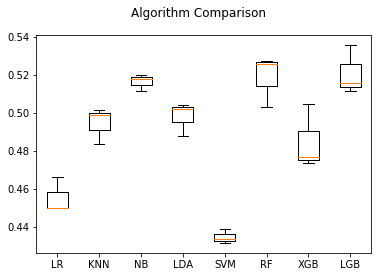

In [48]:
# On Train Data

models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('LGB', LGBMClassifier()))

# evaluate each model in turn
results = []
names = []
seed = 0
for name, model in models:
    kfold = KFold(n_splits=3, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_macro')
    results.append(cv_results)
    
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    

# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

LR: 0.453745 (0.003905)
KNN: 0.485781 (0.019025)
NB: 0.491254 (0.023643)
LDA: 0.506071 (0.016274)
SVM: 0.434670 (0.007128)
RF: 0.500847 (0.022790)
XGB: 0.497898 (0.011930)
LGB: 0.517486 (0.035088)


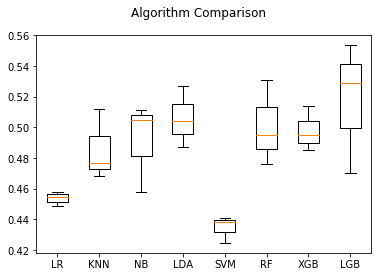

In [49]:
# On Test Data

models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('LGB', LGBMClassifier()))

# evaluate each model in turn
results = []
names = []
seed = 0
for name, model in models:
    kfold = KFold(n_splits=3, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_test, y_test, cv=kfold, scoring='f1_macro')
    results.append(cv_results)
    
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    

# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### Inference

<b>Trained with LGBM, XGBoost, Random Forest and Linear Discriminant Analysis. 
After trying multiple training rounds, found that weighted ensembling of XGboost and LGBM is doing consistently good
So, I'll be showing training of XGboost and LGBM and, will do the final weighted ensembling</b>

## Training

<b>Initially had trained on X_train data i.e. splitted data and tested on X_test data, though after good hyper-parameter optimization, trained models on complete training data, so that it can capture most of the data info/patterms</b>

### XGBoost

In [50]:
# XGB parameters
params={'colsample_bytree': 0.7000000000000002, 'gamma': 0.1, 'learning_rate': 0.09899999999999992, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 149, 'subsample': 0.8000000000000003}

# create the model
xgb = XGBClassifier(min_child_weight=params['min_child_weight'],
                       subsample=params['subsample'],
                       max_depth=params['max_depth'],
                       learning_rate=params['learning_rate'],
                       n_estimators=params['n_estimators'],
                       colsample_bytree=params['colsample_bytree'],
                       gamma=params['gamma'],
                       reg_lambda=30, 
                       reg_alpha=30,
                       verbosity=0,
                       seed=777
                       )

# fit the model
xgb.fit(train[features1], train['Is_Churn'])

XGBClassifier(colsample_bytree=0.7000000000000002, gamma=0.1,
              learning_rate=0.09899999999999992, max_depth=7,
              min_child_weight=5, n_estimators=149, reg_alpha=30, reg_lambda=30,
              seed=777, subsample=0.8000000000000003, verbosity=0)

In [51]:
# evaluate the model

train['xgb_preds'] = xgb.predict_proba(train[features1])[:, 1]

print("_____Train_____")
score_df(train, train['Is_Churn'], 'xgb_preds', 
         [np.round(i,2) for i in list(np.arange(0.1, 1, 0.1, dtype=float))])

_____Train_____


,F1_Score,Accuracy,Class_Count,Class_Ratio
@_0.1,20.181918,24.045113,6650.0,1.0
@_0.2,54.213017,56.300752,6650.0,1.0
@_0.3,61.512650,73.037594,6650.0,1.0
@_0.4,55.645926,77.007519,6650.0,1.0
@_0.5,46.724542,77.338346,6650.0,1.0
@_0.6,43.535518,76.902256,6650.0,1.0
@_0.7,43.466803,76.887218,6650.0,1.0
@_0.8,43.466803,76.887218,6650.0,1.0
@_0.9,43.466803,76.887218,6650.0,1.0


In [52]:
print("_____Train_____")
score_df(train, train['Is_Churn'], 'xgb_preds', 
         [np.round(i,2) for i in list(np.arange(0.2, 0.4, 0.01, dtype=float))])

_____Train_____


,F1_Score,Accuracy,Class_Count,Class_Ratio
@_0.2,54.213017,56.300752,6650.0,1.0
@_0.21,55.614982,58.451128,6650.0,1.0
@_0.22,57.059315,60.781955,6650.0,1.0
@_0.23,58.536139,63.203008,6650.0,1.0
@_0.24,59.217090,64.857143,6650.0,1.0
@_0.25,60.113548,66.766917,6650.0,1.0
@_0.26,60.811014,68.481203,6650.0,1.0
@_0.27,61.234101,69.849624,6650.0,1.0
@_0.28,61.615240,71.067669,6650.0,1.0
@_0.29,61.539297,72.120301,6650.0,1.0


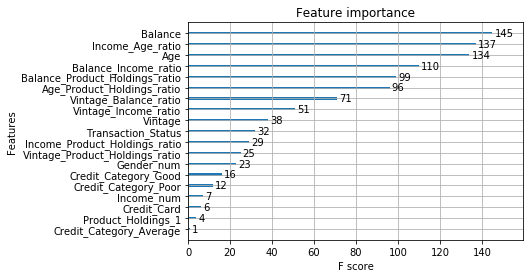

In [53]:
#feature importance
plot_importance(xgb)

### xgb hyp. tuning

In [177]:
#### Hyper Space 

space = {
        'min_child_weight': hp.choice('min_child_weight', list(range(1, 10))),
        'subsample':  hp.choice('subsample', list(np.arange(0.2, 0.8, 0.1,dtype=float))),
        'max_depth':  hp.choice('max_depth', list(range(3, 10))),
        'learning_rate':  hp.choice('learning_rate', list(np.arange(0.01, 0.1, 0.001,dtype=float))),
        'n_estimators':  hp.choice('n_estimators', list(range(50, 200))),
        'colsample_bytree': hp.choice('colsample_bytree', list(np.arange(0.2, 0.8, 0.1,dtype=float))),
        'gamma': hp.choice('gamma', list(np.arange(0.1, 9, 0.1,dtype=float)))
    }

In [210]:
sample(space)

#### Objective 

def objective(params, n_folds=StratifiedKFold(n_splits=10)):
    global ITERATION
    ITERATION += 1
    start = timer()
    cv_result = cross_val_score(XGBClassifier(min_child_weight=params['min_child_weight'],
                                               subsample=params['subsample'],
                                               max_depth=params['max_depth'],
                                               learning_rate=params['learning_rate'],
                                               n_estimators=params['n_estimators'],
                                               colsample_bytree=params['colsample_bytree'],
                                               gamma=params['gamma'],
                                               reg_lambda=20, 
                                               reg_alpha=20,
                                               verbosity=0,
                                               seed=777
                                               ),
        X=np.array(X_train[features1]),
        y=np.array(y_train),
        scoring="f1_macro",
        cv=n_folds,
        verbose=0,
        n_jobs=-1)
    
    run_time = timer() - start
    best_score = np.mean(cv_result)
    mean_score_list.append(best_score)
    print(cv_result)
    loss = 1 - best_score
    n_estimators = int(np.argmax(cv_result) + 1)
    print({
        'best_score': best_score,
        'loss': loss,
        'params': params,
        'iteration': ITERATION,
        'best_cv': n_estimators,
        'train_time': run_time,
        'status': STATUS_OK
    })
    return {
        'best_score': best_score,
        'loss': loss,
        'params': params,
        'iteration': ITERATION,
        'best_cv': n_estimators,
        'train_time': run_time,
        'status': STATUS_OK
    }

[0.434644 0.434644 0.434644 0.434644 0.434644 0.434644 0.434644 0.434644
 0.434644 0.434644]
{'best_score': 0.434643995749203, 'loss': 0.565356004250797, 'params': {'colsample_bytree': 0.30000000000000004, 'gamma': 7.6, 'learning_rate': 0.05999999999999996, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 102, 'subsample': 0.30000000000000004}, 'iteration': 1, 'best_cv': 1, 'train_time': 0.3625821992754936, 'status': 'ok'}
[0.45591255 0.48972558 0.47918472 0.46711741 0.47422171 0.47332335          
 0.48202875 0.48012889 0.47918472 0.46545874]
{'best_score': 0.4746286435605853, 'loss': 0.5253713564394147, 'params': {'colsample_bytree': 0.7000000000000002, 'gamma': 0.1, 'learning_rate': 0.09899999999999992, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 149, 'subsample': 0.8000000000000003}, 'iteration': 2, 'best_cv': 2, 'train_time': 1.3996663466095924, 'status': 'ok'}
[0.434644 0.434644 0.434644 0.434644 0.434644 0.434644 0.434644 0.434644     
 0.434644 0.434644]
{'best

[0.434644   0.4431709  0.434644   0.4431709  0.434644   0.434644              
 0.434644   0.43404255 0.434644   0.434644  ]
{'best_score': 0.43628923216514215, 'loss': 0.5637107678348579, 'params': {'colsample_bytree': 0.6000000000000001, 'gamma': 1.1, 'learning_rate': 0.08399999999999994, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 72, 'subsample': 0.4000000000000001}, 'iteration': 20, 'best_cv': 2, 'train_time': 0.43818825483322144, 'status': 'ok'}
[0.4431709  0.46799553 0.45084103 0.45591255 0.45984364 0.45011303            
 0.4431709  0.45011303 0.45084103 0.44250479]
{'best_score': 0.45145064303347826, 'loss': 0.5485493569665217, 'params': {'colsample_bytree': 0.7000000000000002, 'gamma': 0.1, 'learning_rate': 0.03399999999999998, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 149, 'subsample': 0.6000000000000001}, 'iteration': 21, 'best_cv': 2, 'train_time': 1.1961607336997986, 'status': 'ok'}
[0.46377943 0.4887218  0.4952119  0.46799581 0.46630187 0.47242814

{'best_score': 0.434643995749203, 'loss': 0.565356004250797, 'params': {'colsample_bytree': 0.6000000000000001, 'gamma': 7.4, 'learning_rate': 0.011999999999999999, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 159, 'subsample': 0.6000000000000001}, 'iteration': 38, 'best_cv': 1, 'train_time': 1.147796981036663, 'status': 'ok'}
[0.434644 0.434644 0.434644 0.434644 0.434644 0.434644 0.434644 0.434644      
 0.434644 0.434644]
{'best_score': 0.434643995749203, 'loss': 0.565356004250797, 'params': {'colsample_bytree': 0.7000000000000002, 'gamma': 6.9, 'learning_rate': 0.054999999999999966, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 56, 'subsample': 0.8000000000000003}, 'iteration': 39, 'best_cv': 1, 'train_time': 0.46786896884441376, 'status': 'ok'}
[0.434644 0.434644 0.434644 0.434644 0.434644 0.434644 0.434644 0.434644      
 0.434644 0.434644]
{'best_score': 0.434643995749203, 'loss': 0.565356004250797, 'params': {'colsample_bytree': 0.2, 'gamma': 6.1, 'learning_ra

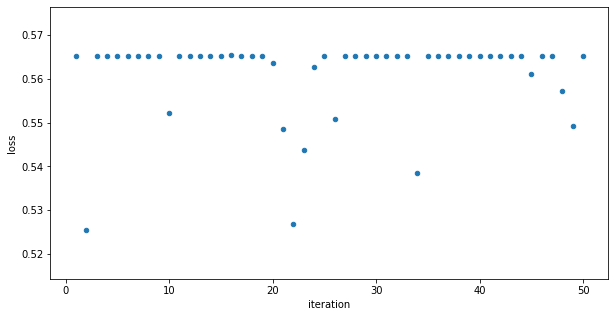

In [211]:
#### Driver 

global mean_score_list
mean_score_list=[]
global max_score_list
max_score_list=[]
global ITERATION
ITERATION = 0
tpe_algorithm = tpe.suggest
bayes_trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=bayes_trials,
            rstate=np.random.RandomState(9),
            verbose=-1)

bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:1]

pd.DataFrame(bayes_trials_results).plot.scatter(x='iteration',y='loss',figsize=(10,5))

### LGBM

In [54]:
# LGBM parameters
params={'bagging_freq': 4, 'feature_fraction': 0.6100000000000003, 'learning_rate': 0.05199999999999997, 
        'max_bin': 9, 'max_depth': 6, 'min_data_in_leaf': 487, 'neg_bagging_fraction': 0.23800000000000004, 
        'num_iterations': 186, 'num_leaves': 10, 'pos_bagging_fraction': 0.5840000000000003}

# create the model
lgb = LGBMClassifier(num_leaves=params['num_leaves'],
                       feature_fraction=params['feature_fraction'],
                       pos_bagging_fraction=params['pos_bagging_fraction'],
                       neg_bagging_fraction=params['neg_bagging_fraction'],
                       max_depth=params['max_depth'],
                       learning_rate=params['learning_rate'],
                       num_iterations=params['num_iterations'],
                       max_bin=params['max_bin'],
                       bagging_freq=params['bagging_freq'],
                       min_data_in_leaf=params['min_data_in_leaf'], 
                       verbose=0,
                       random_state=555
                       )

# fit the model
lgb.fit(train[features1], train['Is_Churn'])

[LightGBM] [Warning] feature_fraction is set=0.6100000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6100000000000003
[LightGBM] [Warning] min_data_in_leaf is set=487, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=487
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6100000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6100000000000003
[LightGBM] [Warning] min_data_in_leaf is set=487, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=487
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

/root/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_freq=4, feature_fraction=0.6100000000000003,
               learning_rate=0.05199999999999997, max_bin=9, max_depth=6,
               min_data_in_leaf=487, neg_bagging_fraction=0.23800000000000004,
               num_iterations=186, num_leaves=10,
               pos_bagging_fraction=0.5840000000000003, random_state=555,
               verbose=0)

In [55]:
# evaluate the model

train['lgb_preds'] = lgb.predict_proba(train[features1])[:, 1]

print("_____Train_____")
score_df(train, train['Is_Churn'], 'lgb_preds', 
         [np.round(i,2) for i in list(np.arange(0.1, 1, 0.1, dtype=float))])

_____Train_____


,F1_Score,Accuracy,Class_Count,Class_Ratio
@_0.1,18.773666,23.112782,6650.0,1.0
@_0.2,21.251724,24.781955,6650.0,1.0
@_0.3,40.870811,40.872180,6650.0,1.0
@_0.4,54.751073,57.909774,6650.0,1.0
@_0.5,59.971653,69.609023,6650.0,1.0
@_0.6,55.838002,76.330827,6650.0,1.0
@_0.7,45.329862,76.932331,6650.0,1.0
@_0.8,43.466803,76.887218,6650.0,1.0
@_0.9,43.466803,76.887218,6650.0,1.0


In [56]:
print("_____Train_____")
score_df(train, train['Is_Churn'], 'lgb_preds', 
         [np.round(i,2) for i in list(np.arange(0.4, 0.6, 0.01, dtype=float))])

_____Train_____


,F1_Score,Accuracy,Class_Count,Class_Ratio
@_0.4,54.751073,57.909774,6650.0,1.0
@_0.41,55.494101,59.157895,6650.0,1.0
@_0.42,55.998604,60.135338,6650.0,1.0
@_0.43,56.572631,61.278195,6650.0,1.0
@_0.44,57.194656,62.481203,6650.0,1.0
@_0.45,57.761824,63.774436,6650.0,1.0
@_0.46,58.348251,65.022556,6650.0,1.0
@_0.47,58.891070,66.330827,6650.0,1.0
@_0.48,59.068109,67.293233,6650.0,1.0
@_0.49,59.662028,68.541353,6650.0,1.0


In [57]:
#feature importance

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    df_imp_f = get_lgbm_varimp_gain(lgb, features1, 400)
            
    display(df_imp_f)
gain_non_zero_list1 = list(df_imp_f['feature_name'][df_imp_f['varimp']>0])
len(gain_non_zero_list1)

,feature_name,varimp
0,Age,1077.12
3,Transaction_Status,325.72
15,Age_Product_Holdings_ratio,236.687
17,Balance_Product_Holdings_ratio,155.31
5,Gender_num,155.052
1,Balance,132.059
11,Income_Age_ratio,122.216
9,Credit_Category_Poor,79.2418
14,Vintage_Income_ratio,58.9217
2,Vintage,49.2743


19

### lgb hyp. tuning

In [116]:
#### Hyper Space 

space = {
        'num_leaves': hp.choice('num_leaves', list(range(10, 40))),
        'feature_fraction':  hp.choice('feature_fraction', list(np.arange(0.2, 0.8, 0.01,dtype=float))),
        'max_depth':  hp.choice('max_depth', list(range(3, 10))),
        'learning_rate':  hp.choice('learning_rate', list(np.arange(0.01, 0.1, 0.001,dtype=float))),
        'num_iterations':  hp.choice('num_iterations', list(range(100, 300))),
        'max_bin': hp.choice('max_bin', list(range(3, 10))),
        'min_data_in_leaf': hp.choice('min_data_in_leaf', list(range(100, 500))),
        'pos_bagging_fraction': hp.choice('pos_bagging_fraction', list(np.arange(0.2, 0.8, 0.001,dtype=float))),
        'neg_bagging_fraction': hp.choice('neg_bagging_fraction', list(np.arange(0.2, 0.8, 0.001,dtype=float))),
        'bagging_freq': hp.choice('bagging_freq', list(range(1, 5)))
    }

In [117]:
sample(space)

#### Objective 

def objective(params, n_folds=StratifiedKFold(n_splits=20)):
    global ITERATION
    ITERATION += 1
    start = timer()
    cv_result = cross_val_score(LGBMClassifier(num_leaves=params['num_leaves'],
                                               feature_fraction=params['feature_fraction'],
                                               pos_bagging_fraction=params['pos_bagging_fraction'],
                                               neg_bagging_fraction=params['neg_bagging_fraction'],
                                               max_depth=params['max_depth'],
                                               learning_rate=params['learning_rate'],
                                               num_iterations=params['num_iterations'],
                                               max_bin=params['max_bin'],
                                               bagging_freq=params['bagging_freq'],
                                               min_data_in_leaf=params['min_data_in_leaf'], 
                                               verbose=0,
                                               random_state=555
                                               ),
        X=np.array(train[features1]),
        y=np.array(train['Is_Churn']),
        scoring="f1_macro",
        cv=n_folds,
        verbose=-1,
        n_jobs=-1)
    
    run_time = timer() - start
    best_score = np.mean(cv_result)
    mean_score_list.append(best_score)
    print(cv_result)
    loss = 1 - best_score
    n_estimators = int(np.argmax(cv_result) + 1)
    print({
        'best_score': best_score,
        'loss': loss,
        'params': params,
        'iteration': ITERATION,
        'best_cv': n_estimators,
        'train_time': run_time,
        'status': STATUS_OK
    })
    return {
        'best_score': best_score,
        'loss': loss,
        'params': params,
        'iteration': ITERATION,
        'best_cv': n_estimators,
        'train_time': run_time,
        'status': STATUS_OK
    }

  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.46015358 0.44819466 0.43463497 0.43463497 0.43463497
 0.44819466 0.43463497 0.44707049 0.43463497 0.4334471  0.4334471
 0.43441227 0.44684626 0.43441227 0.43441227 0.4479741  0.43441227
 0.43537415 0.46250109]
{'best_score': 0.4404331056201296, 'loss': 0.5595668943798704, 'params': {'bagging_freq': 3, 'feature_fraction': 0.5500000000000003, 'learning_rate': 0.023999999999999987, 'max_bin': 4, 'max_depth': 6, 'min_data_in_leaf': 278, 'neg_bagging_fraction': 0.5370000000000004, 'num_iterations': 174, 'num_leaves': 30, 'pos_bagging_fraction': 0.5450000000000004}, 'iteration': 1, 'best_cv': 20, 'train_time': 1.9396798759698868, 'status': 'ok'}
  1%|          | 1/100 [00:02<03:37,  2.20s/it, best loss: 0.5595668943798704]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.9s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.44819466 0.45760942 0.4614323  0.44819466 0.43270869 0.43270869            
 0.46015358 0.43367347 0.45887939 0.43270869 0.43441227 0.4334471
 0.45993151 0.4334471  0.4334471  0.43441227 0.47414384 0.44684626
 0.43537415 0.46250109]
{'best_score': 0.4457113116186653, 'loss': 0.5542886883813347, 'params': {'bagging_freq': 1, 'feature_fraction': 0.5100000000000002, 'learning_rate': 0.09899999999999992, 'max_bin': 6, 'max_depth': 7, 'min_data_in_leaf': 344, 'neg_bagging_fraction': 0.7720000000000005, 'num_iterations': 287, 'num_leaves': 13, 'pos_bagging_fraction': 0.47000000000000025}, 'iteration': 2, 'best_cv': 17, 'train_time': 0.8867955803871155, 'status': 'ok'}
  2%|▏         | 2/100 [00:03<03:03,  1.88s/it, best loss: 0.5542886883813347]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497            
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 1, 'feature_fraction': 0.35000000000000014, 'learning_rate': 0.042999999999999976, 'max_bin': 6, 'max_depth': 8, 'min_data_in_leaf': 360, 'neg_bagging_fraction': 0.6320000000000003, 'num_iterations': 183, 'num_leaves': 33, 'pos_bagging_fraction': 0.23700000000000004}, 'iteration': 3, 'best_cv': 18, 'train_time': 0.541250079870224, 'status': 'ok'}
  3%|▎         | 3/100 [00:04<02:27,  1.52s/it, best loss: 0.5542886883813347]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.57639576 0.54534349 0.546345   0.50275601 0.53337884 0.49215147            
 0.54749697 0.53336616 0.54109541 0.49553098 0.48193762 0.50975275
 0.50191892 0.49375887 0.51104566 0.59586123 0.52707428 0.55535714
 0.55042822 0.53313622]
{'best_score': 0.5287065486603615, 'loss': 0.4712934513396385, 'params': {'bagging_freq': 3, 'feature_fraction': 0.6600000000000004, 'learning_rate': 0.07399999999999994, 'max_bin': 6, 'max_depth': 9, 'min_data_in_leaf': 203, 'neg_bagging_fraction': 0.5040000000000002, 'num_iterations': 142, 'num_leaves': 33, 'pos_bagging_fraction': 0.6790000000000005}, 'iteration': 4, 'best_cv': 16, 'train_time': 0.5399967953562737, 'status': 'ok'}
  4%|▍         | 4/100 [00:04<02:04,  1.29s/it, best loss: 0.4712934513396385]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.63666983 0.58888889 0.56674473 0.58416583 0.5520872  0.58734217            
 0.55656013 0.6222786  0.56733871 0.61141728 0.50708598 0.53999446
 0.52560133 0.57551114 0.61410596 0.65737874 0.60610494 0.59558696
 0.60767631 0.57146739]
{'best_score': 0.5837003291632613, 'loss': 0.4162996708367387, 'params': {'bagging_freq': 3, 'feature_fraction': 0.7800000000000005, 'learning_rate': 0.08499999999999994, 'max_bin': 5, 'max_depth': 6, 'min_data_in_leaf': 203, 'neg_bagging_fraction': 0.25500000000000006, 'num_iterations': 222, 'num_leaves': 10, 'pos_bagging_fraction': 0.6830000000000005}, 'iteration': 5, 'best_cv': 16, 'train_time': 0.6277123838663101, 'status': 'ok'}
  5%|▌         | 5/100 [00:05<01:50,  1.16s/it, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.47293447 0.4459471  0.48698955 0.44707049 0.44707049 0.44819466            
 0.47293447 0.43463497 0.45887939 0.44707049 0.4334471  0.44571918
 0.43150685 0.45865362 0.43247863 0.44684626 0.47414384 0.44571918
 0.4479741  0.47414384]
{'best_score': 0.4526179348681582, 'loss': 0.5473820651318417, 'params': {'bagging_freq': 2, 'feature_fraction': 0.8000000000000005, 'learning_rate': 0.05599999999999996, 'max_bin': 8, 'max_depth': 7, 'min_data_in_leaf': 130, 'neg_bagging_fraction': 0.7460000000000004, 'num_iterations': 130, 'num_leaves': 29, 'pos_bagging_fraction': 0.48000000000000026}, 'iteration': 6, 'best_cv': 3, 'train_time': 0.6394894793629646, 'status': 'ok'}
  6%|▌         | 6/100 [00:06<01:38,  1.04s/it, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497            
 0.43463497 0.43463497 0.44819466 0.43463497 0.43441227 0.43441227
 0.4334471  0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.43529762878912964, 'loss': 0.5647023712108703, 'params': {'bagging_freq': 2, 'feature_fraction': 0.7700000000000005, 'learning_rate': 0.05599999999999996, 'max_bin': 7, 'max_depth': 5, 'min_data_in_leaf': 410, 'neg_bagging_fraction': 0.34500000000000014, 'num_iterations': 102, 'num_leaves': 33, 'pos_bagging_fraction': 0.3030000000000001}, 'iteration': 7, 'best_cv': 9, 'train_time': 0.3013875335454941, 'status': 'ok'}
  7%|▋         | 7/100 [00:06<01:22,  1.12it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.3s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497            
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 2, 'feature_fraction': 0.6500000000000004, 'learning_rate': 0.03899999999999998, 'max_bin': 7, 'max_depth': 6, 'min_data_in_leaf': 330, 'neg_bagging_fraction': 0.6020000000000003, 'num_iterations': 204, 'num_leaves': 18, 'pos_bagging_fraction': 0.2710000000000001}, 'iteration': 8, 'best_cv': 18, 'train_time': 0.6648107096552849, 'status': 'ok'}
  8%|▊         | 8/100 [00:07<01:19,  1.16it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.44819466 0.46015358 0.4614323  0.44819466 0.43367347 0.43367347            
 0.44819466 0.43463497 0.45887939 0.44707049 0.43441227 0.44571918
 0.4334471  0.44684626 0.4334471  0.43441227 0.4479741  0.4479741
 0.43441227 0.46250109]
{'best_score': 0.44476236956376186, 'loss': 0.5552376304362381, 'params': {'bagging_freq': 2, 'feature_fraction': 0.47000000000000025, 'learning_rate': 0.09299999999999993, 'max_bin': 7, 'max_depth': 5, 'min_data_in_leaf': 386, 'neg_bagging_fraction': 0.7870000000000006, 'num_iterations': 105, 'num_leaves': 12, 'pos_bagging_fraction': 0.5810000000000004}, 'iteration': 9, 'best_cv': 20, 'train_time': 0.4220349118113518, 'status': 'ok'}
  9%|▉         | 9/100 [00:08<01:12,  1.25it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.53064142 0.49553098 0.50275601 0.4938355  0.48451027 0.47030753            
 0.55186653 0.49895833 0.52075443 0.52731127 0.49358793 0.46711459
 0.52707384 0.51539666 0.46291035 0.52707428 0.51530934 0.5501355
 0.53520127 0.52246706]
{'best_score': 0.509637155877788, 'loss': 0.490362844122212, 'params': {'bagging_freq': 3, 'feature_fraction': 0.22000000000000003, 'learning_rate': 0.017999999999999995, 'max_bin': 6, 'max_depth': 5, 'min_data_in_leaf': 180, 'neg_bagging_fraction': 0.4020000000000002, 'num_iterations': 213, 'num_leaves': 32, 'pos_bagging_fraction': 0.7410000000000005}, 'iteration': 10, 'best_cv': 7, 'train_time': 0.6556020602583885, 'status': 'ok'}
 10%|█         | 10/100 [00:09<01:14,  1.21it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.54967105 0.52932862 0.54534349 0.48881579 0.50453802 0.48388648             
 0.56647076 0.47775594 0.52534418 0.55782993 0.48361491 0.45843972
 0.52253905 0.53147358 0.53726526 0.5714186  0.52907801 0.50919449
 0.56439716 0.49835165]
{'best_score': 0.5217378353656972, 'loss': 0.4782621646343028, 'params': {'bagging_freq': 2, 'feature_fraction': 0.5500000000000003, 'learning_rate': 0.04999999999999997, 'max_bin': 4, 'max_depth': 9, 'min_data_in_leaf': 169, 'neg_bagging_fraction': 0.34800000000000014, 'num_iterations': 293, 'num_leaves': 31, 'pos_bagging_fraction': 0.48300000000000026}, 'iteration': 11, 'best_cv': 16, 'train_time': 0.8905487954616547, 'status': 'ok'}
 11%|█         | 11/100 [00:10<01:18,  1.13it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497             
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 1, 'feature_fraction': 0.6100000000000003, 'learning_rate': 0.03399999999999998, 'max_bin': 6, 'max_depth': 4, 'min_data_in_leaf': 428, 'neg_bagging_fraction': 0.7630000000000006, 'num_iterations': 275, 'num_leaves': 22, 'pos_bagging_fraction': 0.4110000000000002}, 'iteration': 12, 'best_cv': 18, 'train_time': 0.781363233923912, 'status': 'ok'}
 12%|█▏        | 12/100 [00:11<01:21,  1.08it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497             
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 4, 'feature_fraction': 0.2900000000000001, 'learning_rate': 0.011999999999999999, 'max_bin': 3, 'max_depth': 8, 'min_data_in_leaf': 422, 'neg_bagging_fraction': 0.7720000000000005, 'num_iterations': 200, 'num_leaves': 37, 'pos_bagging_fraction': 0.20500000000000002}, 'iteration': 13, 'best_cv': 18, 'train_time': 0.5757966414093971, 'status': 'ok'}
 13%|█▎        | 13/100 [00:12<01:14,  1.16it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.54169766 0.53337884 0.53336616 0.50453802 0.48934413 0.50453802             
 0.54967105 0.50069129 0.53132917 0.53132917 0.50609193 0.47950728
 0.53052219 0.49897271 0.51479049 0.55933744 0.53314077 0.50919449
 0.51157569 0.51859594]
{'best_score': 0.5190806221335169, 'loss': 0.4809193778664831, 'params': {'bagging_freq': 4, 'feature_fraction': 0.5400000000000003, 'learning_rate': 0.07599999999999994, 'max_bin': 7, 'max_depth': 6, 'min_data_in_leaf': 213, 'neg_bagging_fraction': 0.4270000000000002, 'num_iterations': 161, 'num_leaves': 35, 'pos_bagging_fraction': 0.5360000000000003}, 'iteration': 14, 'best_cv': 16, 'train_time': 0.5343675538897514, 'status': 'ok'}
 14%|█▍        | 14/100 [00:12<01:11,  1.21it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497             
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 1, 'feature_fraction': 0.4400000000000002, 'learning_rate': 0.09099999999999993, 'max_bin': 9, 'max_depth': 3, 'min_data_in_leaf': 387, 'neg_bagging_fraction': 0.7240000000000004, 'num_iterations': 218, 'num_leaves': 19, 'pos_bagging_fraction': 0.2780000000000001}, 'iteration': 15, 'best_cv': 18, 'train_time': 0.6054722443223, 'status': 'ok'}
 15%|█▌        | 15/100 [00:13<01:10,  1.20it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.44819466 0.44707049 0.44819466 0.44819466 0.43463497 0.43463497             
 0.4614323  0.43463497 0.47293447 0.44707049 0.44571918 0.44571918
 0.4479741  0.44684626 0.4334471  0.43441227 0.46121389 0.4479741
 0.43537415 0.44910286]
{'best_score': 0.44623898717385047, 'loss': 0.5537610128261495, 'params': {'bagging_freq': 4, 'feature_fraction': 0.24000000000000005, 'learning_rate': 0.014999999999999996, 'max_bin': 7, 'max_depth': 8, 'min_data_in_leaf': 397, 'neg_bagging_fraction': 0.5650000000000004, 'num_iterations': 226, 'num_leaves': 30, 'pos_bagging_fraction': 0.7370000000000005}, 'iteration': 16, 'best_cv': 9, 'train_time': 0.6294824555516243, 'status': 'ok'}
 16%|█▌        | 16/100 [00:14<01:08,  1.23it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497             
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 2, 'feature_fraction': 0.7500000000000004, 'learning_rate': 0.041999999999999975, 'max_bin': 3, 'max_depth': 7, 'min_data_in_leaf': 195, 'neg_bagging_fraction': 0.6970000000000005, 'num_iterations': 136, 'num_leaves': 29, 'pos_bagging_fraction': 0.35500000000000015}, 'iteration': 17, 'best_cv': 18, 'train_time': 0.5737743601202965, 'status': 'ok'}
 17%|█▋        | 17/100 [00:15<01:07,  1.24it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497             
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 3, 'feature_fraction': 0.3000000000000001, 'learning_rate': 0.015999999999999993, 'max_bin': 6, 'max_depth': 3, 'min_data_in_leaf': 311, 'neg_bagging_fraction': 0.49200000000000027, 'num_iterations': 136, 'num_leaves': 32, 'pos_bagging_fraction': 0.23100000000000004}, 'iteration': 18, 'best_cv': 18, 'train_time': 0.38089364767074585, 'status': 'ok'}
 18%|█▊        | 18/100 [00:15<01:01,  1.33it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.44707049 0.43463497 0.44819466 0.43463497 0.43463497             
 0.4614323  0.43463497 0.46015358 0.43367347 0.43441227 0.43441227
 0.43441227 0.4479741  0.4334471  0.4334471  0.4479741  0.43441227
 0.43537415 0.44910286]
{'best_score': 0.44043339202517656, 'loss': 0.5595666079748234, 'params': {'bagging_freq': 1, 'feature_fraction': 0.6800000000000004, 'learning_rate': 0.08299999999999993, 'max_bin': 8, 'max_depth': 8, 'min_data_in_leaf': 403, 'neg_bagging_fraction': 0.6000000000000003, 'num_iterations': 192, 'num_leaves': 25, 'pos_bagging_fraction': 0.37900000000000017}, 'iteration': 19, 'best_cv': 7, 'train_time': 0.5486032590270042, 'status': 'ok'}
 19%|█▉        | 19/100 [00:16<00:59,  1.37it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.44707049 0.43463497 0.43463497 0.43463497 0.43463497             
 0.44819466 0.43463497 0.44707049 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.4479741  0.43441227
 0.43537415 0.44910286]
{'best_score': 0.43790587170435813, 'loss': 0.5620941282956419, 'params': {'bagging_freq': 1, 'feature_fraction': 0.3000000000000001, 'learning_rate': 0.08399999999999994, 'max_bin': 4, 'max_depth': 3, 'min_data_in_leaf': 378, 'neg_bagging_fraction': 0.3960000000000002, 'num_iterations': 118, 'num_leaves': 33, 'pos_bagging_fraction': 0.3830000000000002}, 'iteration': 20, 'best_cv': 20, 'train_time': 0.3738722428679466, 'status': 'ok'}
 20%|██        | 20/100 [00:17<00:55,  1.44it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.55858961 0.49097731 0.51366035 0.45634338 0.46015358 0.44257993             
 0.48542432 0.46870398 0.49723841 0.46870398 0.47751947 0.43896355
 0.47950728 0.45232156 0.46847291 0.52052296 0.51343429 0.47903758
 0.48364888 0.48056487]
{'best_score': 0.48181840958922084, 'loss': 0.5181815904107792, 'params': {'bagging_freq': 3, 'feature_fraction': 0.6600000000000004, 'learning_rate': 0.07399999999999994, 'max_bin': 5, 'max_depth': 9, 'min_data_in_leaf': 446, 'neg_bagging_fraction': 0.5290000000000004, 'num_iterations': 246, 'num_leaves': 27, 'pos_bagging_fraction': 0.5870000000000004}, 'iteration': 21, 'best_cv': 1, 'train_time': 0.7160103842616081, 'status': 'ok'}
 21%|██        | 21/100 [00:17<00:58,  1.34it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.52662941 0.48934413 0.50243787 0.45887939 0.45887939 0.46453457             
 0.48232695 0.45760942 0.50419868 0.50419868 0.4760101  0.44981061
 0.51157569 0.4826695  0.48364888 0.50397418 0.47903758 0.50045921
 0.48210181 0.46987952]
{'best_score': 0.48441027878962706, 'loss': 0.5155897212103729, 'params': {'bagging_freq': 3, 'feature_fraction': 0.7800000000000005, 'learning_rate': 0.08499999999999994, 'max_bin': 5, 'max_depth': 9, 'min_data_in_leaf': 230, 'neg_bagging_fraction': 0.6570000000000005, 'num_iterations': 238, 'num_leaves': 10, 'pos_bagging_fraction': 0.6300000000000003}, 'iteration': 22, 'best_cv': 1, 'train_time': 0.8094639405608177, 'status': 'ok'}
 22%|██▏       | 22/100 [00:19<01:05,  1.19it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.44819466 0.46870398 0.48542432 0.44819466 0.43367347 0.4459471              
 0.44707049 0.43463497 0.47151687 0.4459471  0.44571918 0.43247863
 0.45737993 0.43247863 0.44571918 0.44571918 0.46121389 0.46121389
 0.43537415 0.47558152]
{'best_score': 0.45110929104132325, 'loss': 0.5488907089586768, 'params': {'bagging_freq': 3, 'feature_fraction': 0.38000000000000017, 'learning_rate': 0.08599999999999992, 'max_bin': 5, 'max_depth': 6, 'min_data_in_leaf': 193, 'neg_bagging_fraction': 0.4190000000000002, 'num_iterations': 115, 'num_leaves': 15, 'pos_bagging_fraction': 0.36400000000000016}, 'iteration': 23, 'best_cv': 3, 'train_time': 0.3886462524533272, 'status': 'ok'}
 23%|██▎       | 23/100 [00:19<00:59,  1.29it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.44819466 0.47293447 0.47436007 0.43463497 0.43367347 0.44819466             
 0.46015358 0.43463497 0.46015358 0.43270869 0.43441227 0.43247863
 0.44684626 0.4334471  0.4334471  0.4479741  0.43441227 0.4334471
 0.43537415 0.46250109]
{'best_score': 0.44469916015236033, 'loss': 0.5553008398476397, 'params': {'bagging_freq': 3, 'feature_fraction': 0.7400000000000004, 'learning_rate': 0.09799999999999992, 'max_bin': 5, 'max_depth': 4, 'min_data_in_leaf': 475, 'neg_bagging_fraction': 0.7270000000000005, 'num_iterations': 142, 'num_leaves': 17, 'pos_bagging_fraction': 0.5600000000000003}, 'iteration': 24, 'best_cv': 3, 'train_time': 0.49570488184690475, 'status': 'ok'}
 24%|██▍       | 24/100 [00:20<00:55,  1.36it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497             
 0.4614323  0.43463497 0.44819466 0.43463497 0.43441227 0.4479741
 0.4479741  0.43247863 0.43441227 0.43441227 0.43441227 0.43441227
 0.43537415 0.43537415]
{'best_score': 0.4378971605588823, 'loss': 0.5621028394411177, 'params': {'bagging_freq': 3, 'feature_fraction': 0.5600000000000003, 'learning_rate': 0.08499999999999994, 'max_bin': 9, 'max_depth': 9, 'min_data_in_leaf': 123, 'neg_bagging_fraction': 0.6620000000000004, 'num_iterations': 222, 'num_leaves': 10, 'pos_bagging_fraction': 0.25200000000000006}, 'iteration': 25, 'best_cv': 7, 'train_time': 0.71812504529953, 'status': 'ok'}
 25%|██▌       | 25/100 [00:21<00:59,  1.25it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497             
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 3, 'feature_fraction': 0.6600000000000004, 'learning_rate': 0.06999999999999995, 'max_bin': 5, 'max_depth': 9, 'min_data_in_leaf': 464, 'neg_bagging_fraction': 0.36700000000000016, 'num_iterations': 216, 'num_leaves': 14, 'pos_bagging_fraction': 0.21600000000000003}, 'iteration': 26, 'best_cv': 18, 'train_time': 0.4868563860654831, 'status': 'ok'}
 26%|██▌       | 26/100 [00:21<00:57,  1.29it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.56882283 0.50069129 0.5226947  0.47775594 0.48232695 0.46730789             
 0.51366035 0.49723841 0.48451027 0.49895833 0.48855634 0.49528732
 0.50919449 0.5310986  0.4826695  0.50790514 0.51479049 0.47450904
 0.47271457 0.51343429]
{'best_score': 0.5002063376394463, 'loss': 0.49979366236055367, 'params': {'bagging_freq': 3, 'feature_fraction': 0.5800000000000003, 'learning_rate': 0.07399999999999994, 'max_bin': 3, 'max_depth': 6, 'min_data_in_leaf': 200, 'neg_bagging_fraction': 0.21000000000000002, 'num_iterations': 266, 'num_leaves': 21, 'pos_bagging_fraction': 0.2750000000000001}, 'iteration': 27, 'best_cv': 1, 'train_time': 0.5799530148506165, 'status': 'ok'}
 27%|██▋       | 27/100 [00:22<00:55,  1.31it/s, best loss: 0.4162996708367387]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.65160075 0.57727558 0.56762503 0.56762503 0.57036878 0.58893502             
 0.56798493 0.60846561 0.57036878 0.6012931  0.57234865 0.52795163
 0.5455983  0.6086444  0.63272354 0.62861957 0.59110338 0.56774895
 0.60783636 0.58836171]
{'best_score': 0.5871239555587155, 'loss': 0.41287604444128445, 'params': {'bagging_freq': 3, 'feature_fraction': 0.5300000000000002, 'learning_rate': 0.027999999999999983, 'max_bin': 9, 'max_depth': 6, 'min_data_in_leaf': 296, 'neg_bagging_fraction': 0.20500000000000002, 'num_iterations': 180, 'num_leaves': 34, 'pos_bagging_fraction': 0.45100000000000023}, 'iteration': 28, 'best_cv': 1, 'train_time': 0.4353009834885597, 'status': 'ok'}
 28%|██▊       | 28/100 [00:23<00:52,  1.36it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.49427964 0.48232695 0.4838703  0.4459471  0.43367347 0.44145803              
 0.49763376 0.43270869 0.45887939 0.47151687 0.44121511 0.44459268
 0.48056487 0.45484401 0.44571918 0.45865362 0.47271457 0.44571918
 0.47129327 0.47558152]
{'best_score': 0.46165960975257914, 'loss': 0.5383403902474209, 'params': {'bagging_freq': 3, 'feature_fraction': 0.5300000000000002, 'learning_rate': 0.07299999999999994, 'max_bin': 9, 'max_depth': 6, 'min_data_in_leaf': 296, 'neg_bagging_fraction': 0.6330000000000005, 'num_iterations': 223, 'num_leaves': 34, 'pos_bagging_fraction': 0.5370000000000004}, 'iteration': 29, 'best_cv': 7, 'train_time': 0.7782154828310013, 'status': 'ok'}
 29%|██▉       | 29/100 [00:24<00:55,  1.27it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.62695473 0.62841202 0.55668719 0.55816011 0.54656968 0.56783468              
 0.61195398 0.60024951 0.53673498 0.60706861 0.53393288 0.5348881
 0.51770129 0.57784483 0.63806035 0.65044966 0.58968927 0.61169591
 0.58723903 0.57784251]
{'best_score': 0.5829984659046558, 'loss': 0.41700153409534424, 'params': {'bagging_freq': 4, 'feature_fraction': 0.36000000000000015, 'learning_rate': 0.05699999999999996, 'max_bin': 9, 'max_depth': 6, 'min_data_in_leaf': 187, 'neg_bagging_fraction': 0.20500000000000002, 'num_iterations': 137, 'num_leaves': 11, 'pos_bagging_fraction': 0.5580000000000003}, 'iteration': 30, 'best_cv': 16, 'train_time': 0.3921327516436577, 'status': 'ok'}
 30%|███       | 30/100 [00:24<00:52,  1.34it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.63564695 0.59345172 0.58656623 0.55512314 0.56798493 0.57159335              
 0.57727558 0.59614607 0.57264438 0.62117092 0.54400125 0.53765597
 0.53140116 0.61955691 0.58793373 0.62752947 0.59351679 0.5655398
 0.62317802 0.57464349]
{'best_score': 0.5841279936774125, 'loss': 0.4158720063225875, 'params': {'bagging_freq': 3, 'feature_fraction': 0.7100000000000004, 'learning_rate': 0.06199999999999996, 'max_bin': 9, 'max_depth': 6, 'min_data_in_leaf': 472, 'neg_bagging_fraction': 0.23300000000000004, 'num_iterations': 187, 'num_leaves': 34, 'pos_bagging_fraction': 0.48200000000000026}, 'iteration': 31, 'best_cv': 1, 'train_time': 0.3925299495458603, 'status': 'ok'}
 31%|███       | 31/100 [00:25<00:49,  1.39it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.49427964 0.48079376 0.47436007 0.45887939 0.45887939 0.44482431              
 0.5095729  0.44707049 0.49427964 0.44482431 0.4400894  0.45611015
 0.49239559 0.45232156 0.44684626 0.47129327 0.4852066  0.46987952
 0.48364888 0.4852066 ]
{'best_score': 0.46953808799879926, 'loss': 0.5304619120012007, 'params': {'bagging_freq': 3, 'feature_fraction': 0.5700000000000003, 'learning_rate': 0.027999999999999983, 'max_bin': 9, 'max_depth': 6, 'min_data_in_leaf': 307, 'neg_bagging_fraction': 0.7110000000000005, 'num_iterations': 180, 'num_leaves': 34, 'pos_bagging_fraction': 0.7880000000000005}, 'iteration': 32, 'best_cv': 7, 'train_time': 0.6656261086463928, 'status': 'ok'}
 32%|███▏      | 32/100 [00:26<00:50,  1.35it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497              
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 3, 'feature_fraction': 0.7100000000000004, 'learning_rate': 0.06699999999999995, 'max_bin': 9, 'max_depth': 4, 'min_data_in_leaf': 299, 'neg_bagging_fraction': 0.7700000000000005, 'num_iterations': 173, 'num_leaves': 20, 'pos_bagging_fraction': 0.3120000000000001}, 'iteration': 33, 'best_cv': 18, 'train_time': 0.6013182774186134, 'status': 'ok'}
 33%|███▎      | 33/100 [00:27<00:51,  1.30it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497              
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 3, 'feature_fraction': 0.26000000000000006, 'learning_rate': 0.027999999999999983, 'max_bin': 9, 'max_depth': 6, 'min_data_in_leaf': 472, 'neg_bagging_fraction': 0.3230000000000001, 'num_iterations': 187, 'num_leaves': 28, 'pos_bagging_fraction': 0.35600000000000015}, 'iteration': 34, 'best_cv': 18, 'train_time': 0.4128631427884102, 'status': 'ok'}
 34%|███▍      | 34/100 [00:27<00:48,  1.36it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.64218107 0.59755022 0.55532805 0.54636273 0.56070113 0.56876457              
 0.57196013 0.61238645 0.53228809 0.59688423 0.53616492 0.5185559
 0.52493549 0.58260719 0.60434322 0.61891644 0.59430038 0.6041751
 0.5916267  0.58888018]
{'best_score': 0.5774456099737965, 'loss': 0.42255439002620354, 'params': {'bagging_freq': 4, 'feature_fraction': 0.4200000000000002, 'learning_rate': 0.06199999999999996, 'max_bin': 9, 'max_depth': 7, 'min_data_in_leaf': 158, 'neg_bagging_fraction': 0.23300000000000004, 'num_iterations': 211, 'num_leaves': 38, 'pos_bagging_fraction': 0.6470000000000005}, 'iteration': 35, 'best_cv': 1, 'train_time': 0.5963098481297493, 'status': 'ok'}
 35%|███▌      | 35/100 [00:28<00:47,  1.36it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497              
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 3, 'feature_fraction': 0.37000000000000016, 'learning_rate': 0.011, 'max_bin': 8, 'max_depth': 6, 'min_data_in_leaf': 407, 'neg_bagging_fraction': 0.7140000000000004, 'num_iterations': 114, 'num_leaves': 36, 'pos_bagging_fraction': 0.37700000000000017}, 'iteration': 36, 'best_cv': 18, 'train_time': 0.4153641313314438, 'status': 'ok'}
 36%|███▌      | 36/100 [00:29<00:45,  1.41it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.51742005 0.49097731 0.49763376 0.45760942 0.45760942 0.46730789              
 0.49262229 0.45887939 0.48079376 0.47010684 0.46567957 0.44571918
 0.47903758 0.47751947 0.48364888 0.45865362 0.48210181 0.47129327
 0.48210181 0.47414384]
{'best_score': 0.4755429578892832, 'loss': 0.5244570421107169, 'params': {'bagging_freq': 3, 'feature_fraction': 0.3900000000000002, 'learning_rate': 0.06199999999999996, 'max_bin': 9, 'max_depth': 6, 'min_data_in_leaf': 110, 'neg_bagging_fraction': 0.7580000000000005, 'num_iterations': 144, 'num_leaves': 39, 'pos_bagging_fraction': 0.6530000000000005}, 'iteration': 37, 'best_cv': 1, 'train_time': 0.6465426161885262, 'status': 'ok'}
 37%|███▋      | 37/100 [00:30<00:46,  1.36it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497              
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 1, 'feature_fraction': 0.7300000000000004, 'learning_rate': 0.01, 'max_bin': 4, 'max_depth': 5, 'min_data_in_leaf': 303, 'neg_bagging_fraction': 0.6060000000000003, 'num_iterations': 221, 'num_leaves': 26, 'pos_bagging_fraction': 0.48200000000000026}, 'iteration': 38, 'best_cv': 18, 'train_time': 0.6551243364810944, 'status': 'ok'}
 38%|███▊      | 38/100 [00:30<00:48,  1.29it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.56647076 0.52336347 0.54534349 0.51883128 0.50453802 0.48133761              
 0.52862535 0.52731127 0.51948052 0.52532895 0.49022292 0.4826695
 0.50975275 0.49033564 0.49528732 0.50429265 0.53935806 0.50919449
 0.53109994 0.52907801]
{'best_score': 0.5160961001245926, 'loss': 0.4839038998754074, 'params': {'bagging_freq': 3, 'feature_fraction': 0.3200000000000001, 'learning_rate': 0.08999999999999993, 'max_bin': 9, 'max_depth': 7, 'min_data_in_leaf': 296, 'neg_bagging_fraction': 0.21400000000000002, 'num_iterations': 281, 'num_leaves': 34, 'pos_bagging_fraction': 0.3000000000000001}, 'iteration': 39, 'best_cv': 1, 'train_time': 0.5765221044421196, 'status': 'ok'}
 39%|███▉      | 39/100 [00:31<00:49,  1.23it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.55956371 0.48451027 0.52731127 0.49262229 0.50419868 0.47775594              
 0.50996656 0.49262229 0.49895833 0.51180556 0.48426443 0.46857993
 0.50919449 0.52116536 0.46707305 0.50973285 0.5022096  0.52116536
 0.49699864 0.51157569]
{'best_score': 0.5025637143016823, 'loss': 0.49743628569831766, 'params': {'bagging_freq': 2, 'feature_fraction': 0.49000000000000027, 'learning_rate': 0.06799999999999995, 'max_bin': 8, 'max_depth': 6, 'min_data_in_leaf': 100, 'neg_bagging_fraction': 0.6350000000000005, 'num_iterations': 120, 'num_leaves': 23, 'pos_bagging_fraction': 0.6980000000000004}, 'iteration': 40, 'best_cv': 1, 'train_time': 0.551378920674324, 'status': 'ok'}
 40%|████      | 40/100 [00:32<00:46,  1.29it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.50597434 0.47625039 0.50776552 0.45760942 0.45760942 0.45382201              
 0.50776552 0.4459471  0.50243787 0.48079376 0.46429212 0.45232156
 0.48910985 0.45358123 0.44571918 0.46707305 0.48210181 0.48210181
 0.48364888 0.48677551]
{'best_score': 0.4751350166689677, 'loss': 0.5248649833310324, 'params': {'bagging_freq': 3, 'feature_fraction': 0.6200000000000003, 'learning_rate': 0.03499999999999998, 'max_bin': 9, 'max_depth': 4, 'min_data_in_leaf': 215, 'neg_bagging_fraction': 0.6140000000000003, 'num_iterations': 243, 'num_leaves': 16, 'pos_bagging_fraction': 0.6420000000000003}, 'iteration': 41, 'best_cv': 3, 'train_time': 0.8007067516446114, 'status': 'ok'}
 41%|████      | 41/100 [00:33<00:50,  1.17it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43367347 0.43463497 0.43463497 0.43463497 0.43463497              
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227
 0.43537415 0.43537415]
{'best_score': 0.4345717332785092, 'loss': 0.5654282667214908, 'params': {'bagging_freq': 2, 'feature_fraction': 0.6900000000000004, 'learning_rate': 0.09699999999999992, 'max_bin': 4, 'max_depth': 5, 'min_data_in_leaf': 354, 'neg_bagging_fraction': 0.5890000000000004, 'num_iterations': 215, 'num_leaves': 34, 'pos_bagging_fraction': 0.22900000000000004}, 'iteration': 42, 'best_cv': 19, 'train_time': 0.6500092074275017, 'status': 'ok'}
 42%|████▏     | 42/100 [00:34<00:50,  1.16it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497              
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 4, 'feature_fraction': 0.4100000000000002, 'learning_rate': 0.028999999999999984, 'max_bin': 3, 'max_depth': 6, 'min_data_in_leaf': 471, 'neg_bagging_fraction': 0.7510000000000006, 'num_iterations': 253, 'num_leaves': 13, 'pos_bagging_fraction': 0.6290000000000004}, 'iteration': 43, 'best_cv': 18, 'train_time': 0.7830618321895599, 'status': 'ok'}
 43%|████▎     | 43/100 [00:35<00:50,  1.14it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.49763376 0.47625039 0.47927025 0.48079376 0.47927025 0.44033613              
 0.5375     0.45887939 0.49723841 0.49097731 0.46429212 0.45232156
 0.50045921 0.4760101  0.44571918 0.5022096  0.5022096  0.52640938
 0.50935961 0.5057536 ]
{'best_score': 0.48614468022635116, 'loss': 0.5138553197736488, 'params': {'bagging_freq': 1, 'feature_fraction': 0.7600000000000005, 'learning_rate': 0.05899999999999996, 'max_bin': 6, 'max_depth': 3, 'min_data_in_leaf': 101, 'neg_bagging_fraction': 0.5620000000000003, 'num_iterations': 179, 'num_leaves': 34, 'pos_bagging_fraction': 0.6170000000000004}, 'iteration': 44, 'best_cv': 7, 'train_time': 0.4917086139321327, 'status': 'ok'}
 44%|████▍     | 44/100 [00:36<00:47,  1.19it/s, best loss: 0.41287604444128445]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.62336147 0.59602787 0.56331738 0.56558349 0.56091453 0.58041832              
 0.59164454 0.63860465 0.54320988 0.61052632 0.55160209 0.56499271
 0.53923348 0.59430038 0.62905028 0.64695297 0.58960715 0.63374969
 0.61605674 0.59273699]
{'best_score': 0.5915945466759395, 'loss': 0.40840545332406053, 'params': {'bagging_freq': 3, 'feature_fraction': 0.7200000000000004, 'learning_rate': 0.07699999999999994, 'max_bin': 9, 'max_depth': 6, 'min_data_in_leaf': 269, 'neg_bagging_fraction': 0.3040000000000001, 'num_iterations': 131, 'num_leaves': 12, 'pos_bagging_fraction': 0.7650000000000006}, 'iteration': 45, 'best_cv': 16, 'train_time': 0.40623296797275543, 'status': 'ok'}
 45%|████▌     | 45/100 [00:36<00:41,  1.33it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.63513514 0.57997936 0.55916008 0.56585249 0.59005891 0.56126482              
 0.56141813 0.57944891 0.54181187 0.59694989 0.56978897 0.56324497
 0.52840295 0.6047619  0.61457702 0.66685346 0.63569704 0.57856878
 0.63672627 0.58265242]
{'best_score': 0.5876176685785918, 'loss': 0.41238233142140823, 'params': {'bagging_freq': 2, 'feature_fraction': 0.7200000000000004, 'learning_rate': 0.07699999999999994, 'max_bin': 7, 'max_depth': 8, 'min_data_in_leaf': 444, 'neg_bagging_fraction': 0.35200000000000015, 'num_iterations': 247, 'num_leaves': 12, 'pos_bagging_fraction': 0.7650000000000006}, 'iteration': 46, 'best_cv': 16, 'train_time': 0.6782562881708145, 'status': 'ok'}
 46%|████▌     | 46/100 [00:37<00:43,  1.25it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.65214751 0.58597348 0.58692185 0.55644223 0.55544923 0.55322004              
 0.58138046 0.60413199 0.55199838 0.60197935 0.51294709 0.5620548
 0.51807229 0.59642366 0.61869627 0.6390622  0.60767631 0.59198336
 0.62712521 0.56741378]
{'best_score': 0.5835549741825947, 'loss': 0.4164450258174053, 'params': {'bagging_freq': 2, 'feature_fraction': 0.5200000000000002, 'learning_rate': 0.09999999999999992, 'max_bin': 7, 'max_depth': 8, 'min_data_in_leaf': 298, 'neg_bagging_fraction': 0.3050000000000001, 'num_iterations': 131, 'num_leaves': 12, 'pos_bagging_fraction': 0.7650000000000006}, 'iteration': 47, 'best_cv': 1, 'train_time': 0.42134077101945877, 'status': 'ok'}
 47%|████▋     | 47/100 [00:38<00:41,  1.27it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.6646981  0.59459459 0.57311223 0.52706767 0.51189215 0.5595608               
 0.57098329 0.61205292 0.56184211 0.5877361  0.48286604 0.52621064
 0.50906519 0.56560748 0.59269683 0.63149716 0.5777335  0.60342075
 0.59690337 0.56365795]
{'best_score': 0.5706599433673534, 'loss': 0.4293400566326466, 'params': {'bagging_freq': 2, 'feature_fraction': 0.7200000000000004, 'learning_rate': 0.04499999999999997, 'max_bin': 7, 'max_depth': 8, 'min_data_in_leaf': 181, 'neg_bagging_fraction': 0.25000000000000006, 'num_iterations': 145, 'num_leaves': 12, 'pos_bagging_fraction': 0.7650000000000006}, 'iteration': 48, 'best_cv': 1, 'train_time': 0.48121287673711777, 'status': 'ok'}
 48%|████▊     | 48/100 [00:38<00:38,  1.36it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497              
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 2, 'feature_fraction': 0.7200000000000004, 'learning_rate': 0.024999999999999988, 'max_bin': 7, 'max_depth': 8, 'min_data_in_leaf': 498, 'neg_bagging_fraction': 0.45300000000000024, 'num_iterations': 265, 'num_leaves': 24, 'pos_bagging_fraction': 0.2720000000000001}, 'iteration': 49, 'best_cv': 18, 'train_time': 0.6440978497266769, 'status': 'ok'}
 49%|████▉     | 49/100 [00:39<00:39,  1.28it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.47436007 0.49427964 0.47293447 0.4838703  0.47293447 0.44370197              
 0.48542432 0.43367347 0.46870398 0.4459471  0.45737993 0.4434666
 0.46429212 0.45611015 0.4334471  0.44571918 0.48677551 0.49573071
 0.48210181 0.49741824]
{'best_score': 0.4669135573256569, 'loss': 0.5330864426743431, 'params': {'bagging_freq': 2, 'feature_fraction': 0.2700000000000001, 'learning_rate': 0.07699999999999994, 'max_bin': 7, 'max_depth': 8, 'min_data_in_leaf': 377, 'neg_bagging_fraction': 0.35800000000000015, 'num_iterations': 230, 'num_leaves': 12, 'pos_bagging_fraction': 0.36100000000000015}, 'iteration': 50, 'best_cv': 20, 'train_time': 0.5314314886927605, 'status': 'ok'}
 50%|█████     | 50/100 [00:40<00:38,  1.29it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497              
 0.43463497 0.43463497 0.44819466 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.4479741  0.43441227
 0.43537415 0.44910286]
{'best_score': 0.4366623197970495, 'loss': 0.5633376802029505, 'params': {'bagging_freq': 2, 'feature_fraction': 0.23000000000000004, 'learning_rate': 0.07699999999999994, 'max_bin': 7, 'max_depth': 8, 'min_data_in_leaf': 444, 'neg_bagging_fraction': 0.7150000000000005, 'num_iterations': 219, 'num_leaves': 12, 'pos_bagging_fraction': 0.3950000000000002}, 'iteration': 51, 'best_cv': 20, 'train_time': 0.6223580092191696, 'status': 'ok'}
 51%|█████     | 51/100 [00:41<00:37,  1.30it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.59992933 0.54849812 0.51755391 0.52534418 0.5375     0.50579505              
 0.54109541 0.51883128 0.53281549 0.58731856 0.50975275 0.53609688
 0.53198701 0.5346036  0.52311233 0.59435023 0.55758614 0.54662936
 0.56671136 0.52707384]
{'best_score': 0.5421292424329494, 'loss': 0.45787075756705065, 'params': {'bagging_freq': 2, 'feature_fraction': 0.6300000000000003, 'learning_rate': 0.07199999999999994, 'max_bin': 6, 'max_depth': 7, 'min_data_in_leaf': 246, 'neg_bagging_fraction': 0.2880000000000001, 'num_iterations': 167, 'num_leaves': 37, 'pos_bagging_fraction': 0.4280000000000002}, 'iteration': 52, 'best_cv': 1, 'train_time': 0.45975038409233093, 'status': 'ok'}
 52%|█████▏    | 52/100 [00:42<00:35,  1.33it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.50419868 0.48772224 0.49594993 0.44370197 0.48542432 0.46730789              
 0.51742005 0.4459471  0.48934413 0.47151687 0.47903758 0.45484401
 0.49872242 0.48910985 0.44121511 0.45484401 0.49573071 0.49405669
 0.48056487 0.47129327]
{'best_score': 0.47839758357537665, 'loss': 0.5216024164246233, 'params': {'bagging_freq': 2, 'feature_fraction': 0.7200000000000004, 'learning_rate': 0.07699999999999994, 'max_bin': 7, 'max_depth': 5, 'min_data_in_leaf': 250, 'neg_bagging_fraction': 0.5070000000000003, 'num_iterations': 106, 'num_leaves': 18, 'pos_bagging_fraction': 0.5270000000000004}, 'iteration': 53, 'best_cv': 7, 'train_time': 0.39544830471277237, 'status': 'ok'}
 53%|█████▎    | 53/100 [00:42<00:32,  1.46it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.63746825 0.58827008 0.58511911 0.55474926 0.56922179 0.60662314              
 0.58933184 0.61569252 0.55014204 0.60543516 0.53916818 0.5325728
 0.52448191 0.58473007 0.59065944 0.64491979 0.5976282  0.5937315
 0.60096154 0.55004671]
{'best_score': 0.5830476658395038, 'loss': 0.41695233416049615, 'params': {'bagging_freq': 4, 'feature_fraction': 0.45000000000000023, 'learning_rate': 0.07799999999999994, 'max_bin': 8, 'max_depth': 8, 'min_data_in_leaf': 266, 'neg_bagging_fraction': 0.3040000000000001, 'num_iterations': 258, 'num_leaves': 35, 'pos_bagging_fraction': 0.6800000000000004}, 'iteration': 54, 'best_cv': 16, 'train_time': 0.676866427063942, 'status': 'ok'}
 54%|█████▍    | 54/100 [00:43<00:34,  1.33it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.53959847 0.50419868 0.50243787 0.48079376 0.49262229 0.4659182               
 0.48934413 0.48232695 0.47625039 0.49097731 0.5022096  0.49074683
 0.48198582 0.51104566 0.48910985 0.47903758 0.51343429 0.45358123
 0.45865362 0.49741824]
{'best_score': 0.4900845386542735, 'loss': 0.5099154613457265, 'params': {'bagging_freq': 1, 'feature_fraction': 0.5900000000000003, 'learning_rate': 0.05999999999999996, 'max_bin': 3, 'max_depth': 3, 'min_data_in_leaf': 159, 'neg_bagging_fraction': 0.35200000000000015, 'num_iterations': 151, 'num_leaves': 19, 'pos_bagging_fraction': 0.44500000000000023}, 'iteration': 55, 'best_cv': 1, 'train_time': 0.5313477143645287, 'status': 'ok'}
 55%|█████▌    | 55/100 [00:44<00:34,  1.31it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.44707049 0.43463497 0.44819466 0.43367347 0.43367347              
 0.44819466 0.43463497 0.46015358 0.43367347 0.4334471  0.4334471
 0.43441227 0.4479741  0.4334471  0.43441227 0.4479741  0.43441227
 0.43537415 0.44910286]
{'best_score': 0.43962710134720756, 'loss': 0.5603728986527925, 'params': {'bagging_freq': 2, 'feature_fraction': 0.5000000000000002, 'learning_rate': 0.06899999999999995, 'max_bin': 4, 'max_depth': 4, 'min_data_in_leaf': 116, 'neg_bagging_fraction': 0.7820000000000005, 'num_iterations': 194, 'num_leaves': 31, 'pos_bagging_fraction': 0.44600000000000023}, 'iteration': 56, 'best_cv': 9, 'train_time': 0.7636614739894867, 'status': 'ok'}
 56%|█████▌    | 56/100 [00:45<00:36,  1.20it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.44819466 0.43463497 0.43463497 0.43463497 0.43463497              
 0.44819466 0.43463497 0.44707049 0.43367347 0.43441227 0.44684626
 0.43441227 0.4479741  0.4334471  0.43441227 0.4479741  0.4479741
 0.43537415 0.44910286]
{'best_score': 0.43984362943361954, 'loss': 0.5601563705663805, 'params': {'bagging_freq': 1, 'feature_fraction': 0.3300000000000001, 'learning_rate': 0.06099999999999996, 'max_bin': 7, 'max_depth': 8, 'min_data_in_leaf': 269, 'neg_bagging_fraction': 0.6370000000000005, 'num_iterations': 220, 'num_leaves': 22, 'pos_bagging_fraction': 0.3850000000000002}, 'iteration': 57, 'best_cv': 20, 'train_time': 0.6414870396256447, 'status': 'ok'}
 57%|█████▋    | 57/100 [00:46<00:36,  1.18it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497              
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 4, 'feature_fraction': 0.2, 'learning_rate': 0.04899999999999997, 'max_bin': 6, 'max_depth': 9, 'min_data_in_leaf': 415, 'neg_bagging_fraction': 0.34000000000000014, 'num_iterations': 247, 'num_leaves': 29, 'pos_bagging_fraction': 0.24800000000000005}, 'iteration': 58, 'best_cv': 18, 'train_time': 0.4976676478981972, 'status': 'ok'}
 58%|█████▊    | 58/100 [00:46<00:34,  1.22it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.61358948 0.55135135 0.56216216 0.55135135 0.55846191 0.56835603              
 0.5363824  0.59609164 0.52177069 0.58244514 0.51755496 0.52344498
 0.5333768  0.58115028 0.59262522 0.63715847 0.57271557 0.5612887
 0.58457274 0.53609688]
{'best_score': 0.5640973383205061, 'loss': 0.4359026616794939, 'params': {'bagging_freq': 2, 'feature_fraction': 0.6000000000000003, 'learning_rate': 0.06299999999999996, 'max_bin': 8, 'max_depth': 3, 'min_data_in_leaf': 112, 'neg_bagging_fraction': 0.37600000000000017, 'num_iterations': 294, 'num_leaves': 12, 'pos_bagging_fraction': 0.6260000000000003}, 'iteration': 59, 'best_cv': 16, 'train_time': 0.7593991458415985, 'status': 'ok'}
 59%|█████▉    | 59/100 [00:47<00:34,  1.18it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.4614323  0.47151687 0.51139722 0.44819466 0.43367347 0.4459471               
 0.47293447 0.43463497 0.47293447 0.45887939 0.44684626 0.43150685
 0.45865362 0.43247863 0.4334471  0.44571918 0.46121389 0.4334471
 0.43441227 0.46250109]
{'best_score': 0.45258854633985823, 'loss': 0.5474114536601418, 'params': {'bagging_freq': 2, 'feature_fraction': 0.7900000000000005, 'learning_rate': 0.040999999999999974, 'max_bin': 5, 'max_depth': 8, 'min_data_in_leaf': 262, 'neg_bagging_fraction': 0.7010000000000005, 'num_iterations': 237, 'num_leaves': 27, 'pos_bagging_fraction': 0.5570000000000004}, 'iteration': 60, 'best_cv': 3, 'train_time': 0.9087560772895813, 'status': 'ok'}
 60%|██████    | 60/100 [00:48<00:37,  1.07it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.56319444 0.49723841 0.52662941 0.49097731 0.49427964 0.46730789              
 0.50597434 0.48079376 0.49553098 0.50069129 0.48748412 0.47450904
 0.48036509 0.50250671 0.4760101  0.5022096  0.48426443 0.46707305
 0.54150884 0.50397418]
{'best_score': 0.4971261312103524, 'loss': 0.5028738687896477, 'params': {'bagging_freq': 1, 'feature_fraction': 0.3100000000000001, 'learning_rate': 0.035999999999999976, 'max_bin': 3, 'max_depth': 7, 'min_data_in_leaf': 257, 'neg_bagging_fraction': 0.2770000000000001, 'num_iterations': 229, 'num_leaves': 30, 'pos_bagging_fraction': 0.4310000000000002}, 'iteration': 61, 'best_cv': 1, 'train_time': 0.5909428969025612, 'status': 'ok'}
 61%|██████    | 61/100 [00:49<00:34,  1.14it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497              
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 4, 'feature_fraction': 0.2800000000000001, 'learning_rate': 0.018999999999999993, 'max_bin': 7, 'max_depth': 5, 'min_data_in_leaf': 153, 'neg_bagging_fraction': 0.5000000000000002, 'num_iterations': 113, 'num_leaves': 14, 'pos_bagging_fraction': 0.3940000000000002}, 'iteration': 62, 'best_cv': 18, 'train_time': 0.38079652190208435, 'status': 'ok'}
 62%|██████▏   | 62/100 [00:50<00:30,  1.26it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.45760942 0.44819466 0.44819466 0.43463497 0.44707049              
 0.44707049 0.43367347 0.46015358 0.4459471  0.4334471  0.44571918
 0.4479741  0.44571918 0.4334471  0.4479741  0.4479741  0.45993151
 0.43537415 0.46121389]
{'best_score': 0.4457979113369899, 'loss': 0.5542020886630101, 'params': {'bagging_freq': 2, 'feature_fraction': 0.6700000000000004, 'learning_rate': 0.06499999999999995, 'max_bin': 4, 'max_depth': 4, 'min_data_in_leaf': 113, 'neg_bagging_fraction': 0.38000000000000017, 'num_iterations': 206, 'num_leaves': 17, 'pos_bagging_fraction': 0.26700000000000007}, 'iteration': 63, 'best_cv': 20, 'train_time': 0.6527998000383377, 'status': 'ok'}
 63%|██████▎   | 63/100 [00:51<00:31,  1.19it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.46015358 0.48232695 0.4614323  0.4459471  0.43367347 0.43270869              
 0.48698955 0.43463497 0.49427964 0.4459471  0.45737993 0.44571918
 0.45737993 0.4434666  0.4334471  0.4479741  0.47414384 0.45993151
 0.45993151 0.47558152]
{'best_score': 0.456652428507531, 'loss': 0.5433475714924689, 'params': {'bagging_freq': 2, 'feature_fraction': 0.46000000000000024, 'learning_rate': 0.06399999999999995, 'max_bin': 7, 'max_depth': 9, 'min_data_in_leaf': 291, 'neg_bagging_fraction': 0.35100000000000015, 'num_iterations': 139, 'num_leaves': 11, 'pos_bagging_fraction': 0.3280000000000001}, 'iteration': 64, 'best_cv': 9, 'train_time': 0.41384102404117584, 'status': 'ok'}
 64%|██████▍   | 64/100 [00:51<00:27,  1.33it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.60215054 0.53692115 0.53999326 0.51948052 0.53790982 0.52932862              
 0.57165207 0.56007509 0.54475977 0.55782993 0.52944626 0.49482654
 0.5612887  0.52344498 0.53198701 0.62403411 0.58300188 0.56675824
 0.5737826  0.53764325]
{'best_score': 0.5513157171406835, 'loss': 0.4486842828593165, 'params': {'bagging_freq': 3, 'feature_fraction': 0.34000000000000014, 'learning_rate': 0.02699999999999999, 'max_bin': 5, 'max_depth': 8, 'min_data_in_leaf': 227, 'neg_bagging_fraction': 0.3870000000000002, 'num_iterations': 131, 'num_leaves': 25, 'pos_bagging_fraction': 0.7330000000000005}, 'iteration': 65, 'best_cv': 16, 'train_time': 0.4136856868863106, 'status': 'ok'}
 65%|██████▌   | 65/100 [00:52<00:25,  1.38it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.52125139 0.50069129 0.51932638 0.47151687 0.47010684 0.45634338              
 0.51742005 0.45887939 0.50069129 0.45634338 0.46429212 0.47450904
 0.47950728 0.43896355 0.46847291 0.53938447 0.51720154 0.49239559
 0.50754851 0.50397418]
{'best_score': 0.48794097295233085, 'loss': 0.5120590270476691, 'params': {'bagging_freq': 3, 'feature_fraction': 0.5300000000000002, 'learning_rate': 0.030999999999999986, 'max_bin': 9, 'max_depth': 6, 'min_data_in_leaf': 264, 'neg_bagging_fraction': 0.22600000000000003, 'num_iterations': 247, 'num_leaves': 15, 'pos_bagging_fraction': 0.2920000000000001}, 'iteration': 66, 'best_cv': 16, 'train_time': 0.5379069522023201, 'status': 'ok'}
 66%|██████▌   | 66/100 [00:53<00:25,  1.35it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.61451599 0.59174217 0.58787129 0.54001554 0.5177854  0.54947886              
 0.57311223 0.60470085 0.55245637 0.5974001  0.51919153 0.53095479
 0.52223967 0.59151134 0.62196356 0.62497869 0.57306977 0.5625466
 0.54890814 0.56567242]
{'best_score': 0.5695057655921211, 'loss': 0.43049423440787893, 'params': {'bagging_freq': 3, 'feature_fraction': 0.4300000000000002, 'learning_rate': 0.03199999999999998, 'max_bin': 9, 'max_depth': 6, 'min_data_in_leaf': 494, 'neg_bagging_fraction': 0.20500000000000002, 'num_iterations': 160, 'num_leaves': 38, 'pos_bagging_fraction': 0.6190000000000004}, 'iteration': 67, 'best_cv': 16, 'train_time': 0.34951628744602203, 'status': 'ok'}
 67%|██████▋   | 67/100 [00:53<00:21,  1.50it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.3s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.44707049 0.44819466 0.43463497 0.43463497 0.43463497              
 0.44819466 0.43463497 0.46015358 0.43463497 0.43441227 0.4334471
 0.4334471  0.4334471  0.43441227 0.43441227 0.46121389 0.43441227
 0.43537415 0.44910286]
{'best_score': 0.43975522534277084, 'loss': 0.5602447746572292, 'params': {'bagging_freq': 3, 'feature_fraction': 0.7000000000000004, 'learning_rate': 0.03699999999999998, 'max_bin': 9, 'max_depth': 6, 'min_data_in_leaf': 219, 'neg_bagging_fraction': 0.7080000000000004, 'num_iterations': 197, 'num_leaves': 21, 'pos_bagging_fraction': 0.4230000000000002}, 'iteration': 68, 'best_cv': 17, 'train_time': 0.7296591177582741, 'status': 'ok'}
 68%|██████▊   | 68/100 [00:54<00:24,  1.32it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.61886854 0.56017923 0.55794504 0.5420932  0.57200627 0.55339954              
 0.54320988 0.56007509 0.5533023  0.56243261 0.52451372 0.50058683
 0.52743271 0.52193627 0.53351517 0.60191847 0.54825204 0.54891304
 0.58056868 0.55521531]
{'best_score': 0.5533181971509753, 'loss': 0.4466818028490247, 'params': {'bagging_freq': 3, 'feature_fraction': 0.25000000000000006, 'learning_rate': 0.029999999999999985, 'max_bin': 9, 'max_depth': 6, 'min_data_in_leaf': 347, 'neg_bagging_fraction': 0.37400000000000017, 'num_iterations': 201, 'num_leaves': 33, 'pos_bagging_fraction': 0.6810000000000005}, 'iteration': 69, 'best_cv': 1, 'train_time': 0.5161917880177498, 'status': 'ok'}
 69%|██████▉   | 69/100 [00:55<00:22,  1.38it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497              
 0.44819466 0.43463497 0.4614323  0.43463497 0.43441227 0.43441227
 0.43441227 0.4334471  0.43441227 0.43441227 0.43441227 0.43441227
 0.43537415 0.44910286]
{'best_score': 0.4372758361456402, 'loss': 0.5627241638543599, 'params': {'bagging_freq': 3, 'feature_fraction': 0.48000000000000026, 'learning_rate': 0.054999999999999966, 'max_bin': 9, 'max_depth': 6, 'min_data_in_leaf': 370, 'neg_bagging_fraction': 0.6420000000000003, 'num_iterations': 180, 'num_leaves': 28, 'pos_bagging_fraction': 0.37000000000000016}, 'iteration': 70, 'best_cv': 9, 'train_time': 0.5662382692098618, 'status': 'ok'}
 70%|███████   | 70/100 [00:56<00:22,  1.34it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.44707049 0.45634338 0.4614323  0.43270869 0.43367347 0.44707049              
 0.44707049 0.43270869 0.45634338 0.44707049 0.43247863 0.44459268
 0.44571918 0.43247863 0.45865362 0.44684626 0.45993151 0.44571918
 0.46121389 0.46250109]
{'best_score': 0.447581328094895, 'loss': 0.552418671905105, 'params': {'bagging_freq': 3, 'feature_fraction': 0.6500000000000004, 'learning_rate': 0.08099999999999993, 'max_bin': 9, 'max_depth': 6, 'min_data_in_leaf': 216, 'neg_bagging_fraction': 0.7170000000000005, 'num_iterations': 242, 'num_leaves': 39, 'pos_bagging_fraction': 0.4300000000000002}, 'iteration': 71, 'best_cv': 20, 'train_time': 0.953451432287693, 'status': 'ok'}
 71%|███████   | 71/100 [00:57<00:25,  1.13it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.53267843 0.49895833 0.50996656 0.4659182  0.49262229 0.47475318              
 0.50069129 0.49097731 0.52731127 0.47927025 0.48748412 0.48855634
 0.51479049 0.458796   0.48056487 0.52907801 0.51157569 0.51343429
 0.52442896 0.5022096 ]
{'best_score': 0.49920327456682845, 'loss': 0.5007967254331716, 'params': {'bagging_freq': 3, 'feature_fraction': 0.7700000000000005, 'learning_rate': 0.09599999999999992, 'max_bin': 6, 'max_depth': 3, 'min_data_in_leaf': 114, 'neg_bagging_fraction': 0.3080000000000001, 'num_iterations': 233, 'num_leaves': 26, 'pos_bagging_fraction': 0.3220000000000001}, 'iteration': 72, 'best_cv': 1, 'train_time': 0.597966268658638, 'status': 'ok'}
 72%|███████▏  | 72/100 [00:58<00:23,  1.19it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497              
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 3, 'feature_fraction': 0.35000000000000014, 'learning_rate': 0.012999999999999998, 'max_bin': 9, 'max_depth': 7, 'min_data_in_leaf': 236, 'neg_bagging_fraction': 0.46800000000000025, 'num_iterations': 195, 'num_leaves': 20, 'pos_bagging_fraction': 0.4320000000000002}, 'iteration': 73, 'best_cv': 18, 'train_time': 0.5856969580054283, 'status': 'ok'}
 73%|███████▎  | 73/100 [00:58<00:22,  1.19it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.5986249  0.52142075 0.53692115 0.52534418 0.55286219 0.49047839              
 0.5313452  0.50275601 0.52337512 0.56007509 0.51727869 0.5310986
 0.49343912 0.52650212 0.50191892 0.58300188 0.55095692 0.50919449
 0.58597418 0.52508803]
{'best_score': 0.5333827971024184, 'loss': 0.4666172028975816, 'params': {'bagging_freq': 3, 'feature_fraction': 0.47000000000000025, 'learning_rate': 0.03799999999999998, 'max_bin': 3, 'max_depth': 6, 'min_data_in_leaf': 363, 'neg_bagging_fraction': 0.45700000000000024, 'num_iterations': 190, 'num_leaves': 32, 'pos_bagging_fraction': 0.7650000000000006}, 'iteration': 74, 'best_cv': 1, 'train_time': 0.564069502055645, 'status': 'ok'}
 74%|███████▍  | 74/100 [00:59<00:21,  1.20it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.51553161 0.4659182  0.49427964 0.48542432 0.47293447 0.4838703               
 0.51553161 0.4459471  0.47775594 0.4838703  0.4400894  0.46567957
 0.49872242 0.4601626  0.45737993 0.46847291 0.49911994 0.48056487
 0.48364888 0.46707305]
{'best_score': 0.47809885379163675, 'loss': 0.5219011462083633, 'params': {'bagging_freq': 4, 'feature_fraction': 0.4000000000000002, 'learning_rate': 0.07899999999999993, 'max_bin': 8, 'max_depth': 5, 'min_data_in_leaf': 102, 'neg_bagging_fraction': 0.5050000000000003, 'num_iterations': 156, 'num_leaves': 36, 'pos_bagging_fraction': 0.44700000000000023}, 'iteration': 75, 'best_cv': 1, 'train_time': 0.5493258088827133, 'status': 'ok'}
 75%|███████▌  | 75/100 [01:00<00:19,  1.27it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.49763376 0.46730789 0.47436007 0.47293447 0.4459471  0.4459471               
 0.50776552 0.43270869 0.47927025 0.44482431 0.44684626 0.44121511
 0.47301587 0.4434666  0.44684626 0.47414384 0.50935961 0.46847291
 0.47129327 0.48677551]
{'best_score': 0.4665067191503014, 'loss': 0.5334932808496986, 'params': {'bagging_freq': 1, 'feature_fraction': 0.8000000000000005, 'learning_rate': 0.09499999999999992, 'max_bin': 9, 'max_depth': 4, 'min_data_in_leaf': 412, 'neg_bagging_fraction': 0.2910000000000001, 'num_iterations': 110, 'num_leaves': 12, 'pos_bagging_fraction': 0.3240000000000001}, 'iteration': 76, 'best_cv': 17, 'train_time': 0.3269590884447098, 'status': 'ok'}
 76%|███████▌  | 76/100 [01:00<00:17,  1.38it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.3s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.55632495 0.49723841 0.54597788 0.49895833 0.50419868 0.48451027              
 0.49895833 0.47927025 0.49215147 0.53132917 0.51479049 0.45607593
 0.5310986  0.49189996 0.47950728 0.55933744 0.52442896 0.48426443
 0.51859594 0.51859594]
{'best_score': 0.5083756348359076, 'loss': 0.49162436516409236, 'params': {'bagging_freq': 3, 'feature_fraction': 0.5100000000000002, 'learning_rate': 0.08199999999999993, 'max_bin': 7, 'max_depth': 9, 'min_data_in_leaf': 211, 'neg_bagging_fraction': 0.6920000000000004, 'num_iterations': 155, 'num_leaves': 23, 'pos_bagging_fraction': 0.7860000000000005}, 'iteration': 77, 'best_cv': 16, 'train_time': 0.6511380150914192, 'status': 'ok'}
 77%|███████▋  | 77/100 [01:01<00:17,  1.34it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.44707049 0.43463497 0.43463497 0.43463497 0.43463497              
 0.44819466 0.43463497 0.46015358 0.43463497 0.43441227 0.4334471
 0.43441227 0.43441227 0.43441227 0.43441227 0.4479741  0.43441227
 0.43537415 0.44910286]
{'best_score': 0.4385117678658367, 'loss': 0.5614882321341633, 'params': {'bagging_freq': 3, 'feature_fraction': 0.6400000000000003, 'learning_rate': 0.09399999999999993, 'max_bin': 4, 'max_depth': 6, 'min_data_in_leaf': 333, 'neg_bagging_fraction': 0.7770000000000006, 'num_iterations': 264, 'num_leaves': 16, 'pos_bagging_fraction': 0.37500000000000017}, 'iteration': 78, 'best_cv': 9, 'train_time': 0.9001708552241325, 'status': 'ok'}
 78%|███████▊  | 78/100 [01:02<00:18,  1.16it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.44819466 0.44707049 0.4614323  0.43463497 0.43367347 0.43463497              
 0.44819466 0.43463497 0.44707049 0.43463497 0.43441227 0.4334471
 0.43441227 0.4334471  0.43441227 0.43441227 0.4479741  0.43441227
 0.43537415 0.44910286]
{'best_score': 0.439779130387954, 'loss': 0.560220869612046, 'params': {'bagging_freq': 2, 'feature_fraction': 0.22000000000000003, 'learning_rate': 0.06599999999999995, 'max_bin': 5, 'max_depth': 8, 'min_data_in_leaf': 147, 'neg_bagging_fraction': 0.5720000000000003, 'num_iterations': 111, 'num_leaves': 24, 'pos_bagging_fraction': 0.48900000000000027}, 'iteration': 79, 'best_cv': 3, 'train_time': 0.4192221537232399, 'status': 'ok'}
 79%|███████▉  | 79/100 [01:03<00:16,  1.25it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497              
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 3, 'feature_fraction': 0.21000000000000002, 'learning_rate': 0.013999999999999997, 'max_bin': 9, 'max_depth': 6, 'min_data_in_leaf': 426, 'neg_bagging_fraction': 0.2830000000000001, 'num_iterations': 141, 'num_leaves': 13, 'pos_bagging_fraction': 0.34500000000000014}, 'iteration': 80, 'best_cv': 18, 'train_time': 0.32608941197395325, 'status': 'ok'}
 80%|████████  | 80/100 [01:04<00:13,  1.43it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.3s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497              
 0.43463497 0.43463497 0.44819466 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4353458871282288, 'loss': 0.5646541128717713, 'params': {'bagging_freq': 4, 'feature_fraction': 0.5500000000000003, 'learning_rate': 0.07499999999999994, 'max_bin': 6, 'max_depth': 8, 'min_data_in_leaf': 423, 'neg_bagging_fraction': 0.7950000000000006, 'num_iterations': 117, 'num_leaves': 10, 'pos_bagging_fraction': 0.5050000000000003}, 'iteration': 81, 'best_cv': 9, 'train_time': 0.49831150472164154, 'status': 'ok'}
 81%|████████  | 81/100 [01:04<00:14,  1.35it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.51553161 0.48772224 0.49427964 0.45382201 0.4838703  0.46730789              
 0.49763376 0.44482431 0.48934413 0.48079376 0.47903758 0.45232156
 0.51720154 0.4760101  0.46847291 0.47751947 0.48364888 0.49074683
 0.48056487 0.46987952]
{'best_score': 0.4805266453415955, 'loss': 0.5194733546584045, 'params': {'bagging_freq': 1, 'feature_fraction': 0.7200000000000004, 'learning_rate': 0.047999999999999966, 'max_bin': 7, 'max_depth': 6, 'min_data_in_leaf': 281, 'neg_bagging_fraction': 0.5770000000000004, 'num_iterations': 254, 'num_leaves': 18, 'pos_bagging_fraction': 0.5840000000000003}, 'iteration': 82, 'best_cv': 13, 'train_time': 0.74978157132864, 'status': 'ok'}
 82%|████████▏ | 82/100 [01:05<00:14,  1.22it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.49427964 0.48079376 0.47436007 0.45887939 0.4459471  0.4459471               
 0.48542432 0.43367347 0.47010684 0.44482431 0.44121511 0.4434666
 0.5057536  0.45484401 0.44684626 0.44684626 0.45865362 0.45865362
 0.45993151 0.45993151]
{'best_score': 0.4605189052055412, 'loss': 0.5394810947944588, 'params': {'bagging_freq': 3, 'feature_fraction': 0.2900000000000001, 'learning_rate': 0.05799999999999996, 'max_bin': 9, 'max_depth': 7, 'min_data_in_leaf': 272, 'neg_bagging_fraction': 0.7280000000000004, 'num_iterations': 157, 'num_leaves': 31, 'pos_bagging_fraction': 0.7040000000000004}, 'iteration': 83, 'best_cv': 13, 'train_time': 0.5563833713531494, 'status': 'ok'}
 83%|████████▎ | 83/100 [01:06<00:13,  1.27it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.56647076 0.50814271 0.54320988 0.50814271 0.51553161 0.49723841              
 0.51692456 0.47010684 0.51883128 0.51180556 0.49897271 0.46857993
 0.51539666 0.50191892 0.46429212 0.53314077 0.49358793 0.50609193
 0.57099422 0.50429265]
{'best_score': 0.5106836078491199, 'loss': 0.4893163921508801, 'params': {'bagging_freq': 2, 'feature_fraction': 0.24000000000000005, 'learning_rate': 0.09199999999999993, 'max_bin': 8, 'max_depth': 3, 'min_data_in_leaf': 444, 'neg_bagging_fraction': 0.33400000000000013, 'num_iterations': 262, 'num_leaves': 37, 'pos_bagging_fraction': 0.4380000000000002}, 'iteration': 84, 'best_cv': 19, 'train_time': 0.5734762400388718, 'status': 'ok'}
 84%|████████▍ | 84/100 [01:07<00:12,  1.26it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.59320207 0.50944955 0.52731127 0.49723841 0.53337884 0.46041667              
 0.50633339 0.49097731 0.51948052 0.51503364 0.49548583 0.53313622
 0.48961071 0.5135022  0.50553191 0.5737826  0.52707384 0.50609193
 0.57099422 0.51859594]
{'best_score': 0.5193313550637662, 'loss': 0.48066864493623385, 'params': {'bagging_freq': 3, 'feature_fraction': 0.5400000000000003, 'learning_rate': 0.04399999999999998, 'max_bin': 3, 'max_depth': 5, 'min_data_in_leaf': 241, 'neg_bagging_fraction': 0.2890000000000001, 'num_iterations': 176, 'num_leaves': 12, 'pos_bagging_fraction': 0.45100000000000023}, 'iteration': 85, 'best_cv': 1, 'train_time': 0.48003318905830383, 'status': 'ok'}
 85%|████████▌ | 85/100 [01:08<00:11,  1.35it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.61569252 0.580878   0.56174492 0.55933866 0.59139925 0.57307692              
 0.5549291  0.59288401 0.53165901 0.58888889 0.5401732  0.52375571
 0.53252605 0.5768962  0.6098155  0.64301075 0.58351254 0.57450444
 0.62102187 0.552619  ]
{'best_score': 0.5754163272404211, 'loss': 0.42458367275957887, 'params': {'bagging_freq': 2, 'feature_fraction': 0.7800000000000005, 'learning_rate': 0.052999999999999964, 'max_bin': 9, 'max_depth': 9, 'min_data_in_leaf': 404, 'neg_bagging_fraction': 0.35600000000000015, 'num_iterations': 128, 'num_leaves': 19, 'pos_bagging_fraction': 0.6820000000000004}, 'iteration': 86, 'best_cv': 16, 'train_time': 0.3839559555053711, 'status': 'ok'}
 86%|████████▌ | 86/100 [01:08<00:09,  1.42it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497              
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 3, 'feature_fraction': 0.6100000000000003, 'learning_rate': 0.01999999999999999, 'max_bin': 4, 'max_depth': 4, 'min_data_in_leaf': 421, 'neg_bagging_fraction': 0.3950000000000002, 'num_iterations': 178, 'num_leaves': 35, 'pos_bagging_fraction': 0.4240000000000002}, 'iteration': 87, 'best_cv': 18, 'train_time': 0.45206672698259354, 'status': 'ok'}
 87%|████████▋ | 87/100 [01:09<00:09,  1.43it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.61950373 0.59782609 0.56573252 0.56537283 0.6020641  0.56126482              
 0.55592441 0.62870661 0.54011299 0.59646997 0.56539661 0.54475824
 0.51228632 0.58897504 0.61368805 0.66431668 0.57464349 0.59448613
 0.59827139 0.5859952 ]
{'best_score': 0.5837897617428235, 'loss': 0.4162102382571765, 'params': {'bagging_freq': 4, 'feature_fraction': 0.5300000000000002, 'learning_rate': 0.08899999999999993, 'max_bin': 7, 'max_depth': 8, 'min_data_in_leaf': 449, 'neg_bagging_fraction': 0.35200000000000015, 'num_iterations': 212, 'num_leaves': 15, 'pos_bagging_fraction': 0.7170000000000005}, 'iteration': 88, 'best_cv': 16, 'train_time': 0.534601017832756, 'status': 'ok'}
 88%|████████▊ | 88/100 [01:09<00:08,  1.45it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.6249232  0.60418605 0.57471264 0.56750466 0.57931943 0.58534859              
 0.59169884 0.59131882 0.5585506  0.59082531 0.56978897 0.5370561
 0.54780016 0.57535114 0.60619826 0.65551232 0.61110262 0.61053554
 0.60831537 0.5749794 ]
{'best_score': 0.5882514022696443, 'loss': 0.41174859773035566, 'params': {'bagging_freq': 1, 'feature_fraction': 0.6800000000000004, 'learning_rate': 0.08699999999999992, 'max_bin': 5, 'max_depth': 6, 'min_data_in_leaf': 269, 'neg_bagging_fraction': 0.3040000000000001, 'num_iterations': 116, 'num_leaves': 30, 'pos_bagging_fraction': 0.6970000000000005}, 'iteration': 89, 'best_cv': 16, 'train_time': 0.40743768215179443, 'status': 'ok'}
 89%|████████▉ | 89/100 [01:10<00:07,  1.48it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.52862535 0.50069129 0.50776552 0.44482431 0.47151687 0.44257993              
 0.5095729  0.47010684 0.49723841 0.4459471  0.46153395 0.45106476
 0.50429265 0.46291035 0.45484401 0.46847291 0.5022096  0.53728223
 0.53246962 0.47903758]
{'best_score': 0.48364930923040034, 'loss': 0.5163506907695996, 'params': {'bagging_freq': 1, 'feature_fraction': 0.6800000000000004, 'learning_rate': 0.02099999999999999, 'max_bin': 5, 'max_depth': 6, 'min_data_in_leaf': 157, 'neg_bagging_fraction': 0.3040000000000001, 'num_iterations': 232, 'num_leaves': 30, 'pos_bagging_fraction': 0.37200000000000016}, 'iteration': 90, 'best_cv': 18, 'train_time': 0.7541009113192558, 'status': 'ok'}
 90%|█████████ | 90/100 [01:11<00:08,  1.23it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.52862535 0.48934413 0.5226947  0.45382201 0.46730789 0.44145803              
 0.53064142 0.48232695 0.50453802 0.50776552 0.4601626  0.43896355
 0.4826695  0.458796   0.48056487 0.52640938 0.49074683 0.5022096
 0.51530934 0.48910985]
{'best_score': 0.48867327627756685, 'loss': 0.5113267237224332, 'params': {'bagging_freq': 1, 'feature_fraction': 0.5800000000000003, 'learning_rate': 0.08699999999999992, 'max_bin': 5, 'max_depth': 8, 'min_data_in_leaf': 242, 'neg_bagging_fraction': 0.3040000000000001, 'num_iterations': 122, 'num_leaves': 22, 'pos_bagging_fraction': 0.35800000000000015}, 'iteration': 91, 'best_cv': 7, 'train_time': 0.4054097458720207, 'status': 'ok'}
 91%|█████████ | 91/100 [01:12<00:06,  1.36it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.54597788 0.49723841 0.51315789 0.49553098 0.48772224 0.47326389              
 0.5375     0.48772224 0.50996656 0.52931111 0.49897271 0.48689976
 0.50735675 0.51922767 0.51479049 0.56392563 0.51668533 0.51859594
 0.52640938 0.51668533]
{'best_score': 0.5123470099778744, 'loss': 0.4876529900221256, 'params': {'bagging_freq': 1, 'feature_fraction': 0.6800000000000004, 'learning_rate': 0.08799999999999993, 'max_bin': 5, 'max_depth': 6, 'min_data_in_leaf': 141, 'neg_bagging_fraction': 0.6850000000000005, 'num_iterations': 116, 'num_leaves': 30, 'pos_bagging_fraction': 0.7920000000000005}, 'iteration': 92, 'best_cv': 16, 'train_time': 0.4671691060066223, 'status': 'ok'}
 92%|█████████▏| 92/100 [01:13<00:05,  1.38it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.6478971  0.55121294 0.53175278 0.53584229 0.55992135 0.50219024              
 0.56007509 0.55286219 0.5363824  0.57065498 0.53622649 0.51950667
 0.53807997 0.52592041 0.55683864 0.63207684 0.55768718 0.5680902
 0.60774532 0.55521531]
{'best_score': 0.5573089197923691, 'loss': 0.4426910802076309, 'params': {'bagging_freq': 1, 'feature_fraction': 0.7500000000000004, 'learning_rate': 0.03299999999999998, 'max_bin': 5, 'max_depth': 3, 'min_data_in_leaf': 172, 'neg_bagging_fraction': 0.3120000000000001, 'num_iterations': 196, 'num_leaves': 30, 'pos_bagging_fraction': 0.5390000000000004}, 'iteration': 93, 'best_cv': 1, 'train_time': 0.5996470376849174, 'status': 'ok'}
 93%|█████████▎| 93/100 [01:13<00:05,  1.37it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.5375     0.48772224 0.51180556 0.47151687 0.4838703  0.4659182               
 0.51366035 0.45760942 0.51553161 0.49097731 0.47450904 0.44981061
 0.50429265 0.50073357 0.49074683 0.52442896 0.49405669 0.5022096
 0.49573071 0.48056487]
{'best_score': 0.49265976850890086, 'loss': 0.5073402314910991, 'params': {'bagging_freq': 1, 'feature_fraction': 0.4400000000000002, 'learning_rate': 0.05199999999999997, 'max_bin': 5, 'max_depth': 7, 'min_data_in_leaf': 136, 'neg_bagging_fraction': 0.6260000000000003, 'num_iterations': 184, 'num_leaves': 29, 'pos_bagging_fraction': 0.6630000000000005}, 'iteration': 94, 'best_cv': 1, 'train_time': 0.6680662110447884, 'status': 'ok'}
 94%|█████████▍| 94/100 [01:14<00:04,  1.28it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.43463497 0.43463497 0.43463497              
 0.43463497 0.43463497 0.43463497 0.43463497 0.43441227 0.43441227
 0.43441227 0.43441227 0.43441227 0.43441227 0.43441227 0.43537415
 0.43537415 0.43537415]
{'best_score': 0.4346679027308653, 'loss': 0.5653320972691347, 'params': {'bagging_freq': 1, 'feature_fraction': 0.36000000000000015, 'learning_rate': 0.02599999999999999, 'max_bin': 5, 'max_depth': 5, 'min_data_in_leaf': 441, 'neg_bagging_fraction': 0.7130000000000005, 'num_iterations': 158, 'num_leaves': 27, 'pos_bagging_fraction': 0.3860000000000002}, 'iteration': 95, 'best_cv': 18, 'train_time': 0.45845208317041397, 'status': 'ok'}
 95%|█████████▌| 95/100 [01:15<00:03,  1.32it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.4614323  0.47010684 0.51139722 0.44819466 0.43367347 0.44707049              
 0.47293447 0.43463497 0.47151687 0.4459471  0.44684626 0.43247863
 0.45737993 0.4334471  0.4334471  0.44684626 0.46121389 0.44684626
 0.43537415 0.46121389]
{'best_score': 0.452600094421941, 'loss': 0.547399905578059, 'params': {'bagging_freq': 1, 'feature_fraction': 0.38000000000000017, 'learning_rate': 0.053999999999999965, 'max_bin': 5, 'max_depth': 8, 'min_data_in_leaf': 323, 'neg_bagging_fraction': 0.6950000000000005, 'num_iterations': 236, 'num_leaves': 25, 'pos_bagging_fraction': 0.5630000000000004}, 'iteration': 96, 'best_cv': 3, 'train_time': 0.6961918696761131, 'status': 'ok'}
 96%|█████████▌| 96/100 [01:16<00:03,  1.29it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.52465278 0.49723841 0.52862535 0.48934413 0.50597434 0.48611111              
 0.51932638 0.46870398 0.50633339 0.51553161 0.48910985 0.46567957
 0.50073357 0.48586914 0.46567957 0.47751947 0.51720154 0.50045921
 0.50397418 0.49239559]
{'best_score': 0.49702315908633166, 'loss': 0.5029768409136683, 'params': {'bagging_freq': 1, 'feature_fraction': 0.5600000000000003, 'learning_rate': 0.04599999999999997, 'max_bin': 7, 'max_depth': 4, 'min_data_in_leaf': 325, 'neg_bagging_fraction': 0.5820000000000003, 'num_iterations': 282, 'num_leaves': 12, 'pos_bagging_fraction': 0.6540000000000004}, 'iteration': 97, 'best_cv': 3, 'train_time': 0.7900182604789734, 'status': 'ok'}
 97%|█████████▋| 97/100 [01:17<00:02,  1.17it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43367347 0.4614323  0.44819466 0.43463497 0.43463497              
 0.44707049 0.43463497 0.4614323  0.43270869 0.43441227 0.4334471
 0.47414384 0.44684626 0.43441227 0.43441227 0.46121389 0.43441227
 0.43441227 0.4479741 ]
{'best_score': 0.44293691616186265, 'loss': 0.5570630838381374, 'params': {'bagging_freq': 2, 'feature_fraction': 0.7200000000000004, 'learning_rate': 0.07099999999999995, 'max_bin': 6, 'max_depth': 6, 'min_data_in_leaf': 259, 'neg_bagging_fraction': 0.4080000000000002, 'num_iterations': 279, 'num_leaves': 14, 'pos_bagging_fraction': 0.25500000000000006}, 'iteration': 98, 'best_cv': 13, 'train_time': 0.7702125236392021, 'status': 'ok'}
 98%|█████████▊| 98/100 [01:18<00:01,  1.15it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.43463497 0.43463497 0.43463497 0.44819466 0.43463497 0.43463497              
 0.44819466 0.43463497 0.46015358 0.43367347 0.43441227 0.4334471
 0.43441227 0.43441227 0.4334471  0.43441227 0.46121389 0.43441227
 0.43537415 0.46121389]
{'best_score': 0.4397391842377359, 'loss': 0.5602608157622642, 'params': {'bagging_freq': 1, 'feature_fraction': 0.26000000000000006, 'learning_rate': 0.07699999999999994, 'max_bin': 8, 'max_depth': 9, 'min_data_in_leaf': 321, 'neg_bagging_fraction': 0.7550000000000006, 'num_iterations': 135, 'num_leaves': 17, 'pos_bagging_fraction': 0.5230000000000004}, 'iteration': 99, 'best_cv': 17, 'train_time': 0.4214158281683922, 'status': 'ok'}
 99%|█████████▉| 99/100 [01:18<00:00,  1.24it/s, best loss: 0.40840545332406053]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



[0.50597434 0.45887939 0.5095729  0.47010684 0.43270869 0.46730789              
 0.49763376 0.45760942 0.47775594 0.48542432 0.45993151 0.46847291
 0.46987952 0.47450904 0.48056487 0.49405669 0.48210181 0.45611015
 0.45993151 0.48835616]
{'best_score': 0.4748443827642418, 'loss': 0.5251556172357582, 'params': {'bagging_freq': 2, 'feature_fraction': 0.5700000000000003, 'learning_rate': 0.07999999999999993, 'max_bin': 3, 'max_depth': 6, 'min_data_in_leaf': 144, 'neg_bagging_fraction': 0.6220000000000003, 'num_iterations': 207, 'num_leaves': 11, 'pos_bagging_fraction': 0.5640000000000003}, 'iteration': 100, 'best_cv': 3, 'train_time': 0.7252855896949768, 'status': 'ok'}
100%|██████████| 100/100 [01:19<00:00,  1.25it/s, best loss: 0.40840545332406053]


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished



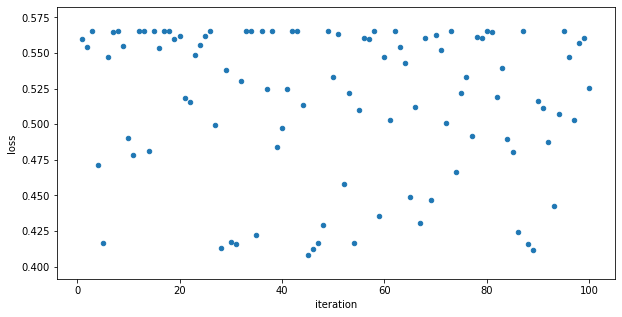

In [119]:
#### Driver 

global mean_score_list
mean_score_list=[]
global max_score_list
max_score_list=[]
global ITERATION
ITERATION = 0
tpe_algorithm = tpe.suggest
bayes_trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=bayes_trials,
            rstate=np.random.RandomState(9),
            verbose=-1)

bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:1]

pd.DataFrame(bayes_trials_results).plot.scatter(x='iteration',y='loss',figsize=(10,5))

### Ensembled

<b>Did weighted ensembling with 0.6 weight to LGBM model and 0.4 to XGBoost model since LGBM was performing little better consistently</b>

In [58]:
# evaluation of ensembled model
train['xgb_lgb'] = 0.4*train['xgb_preds'] + 0.6*train['lgb_preds']

print("_____Train_____")
score_df(train, train['Is_Churn'], 'xgb_lgb', 
         [np.round(i,2) for i in list(np.arange(0.1, 1, 0.1, dtype=float))])

_____Train_____


,F1_Score,Accuracy,Class_Count,Class_Ratio
@_0.1,18.773666,23.112782,6650.0,1.0
@_0.2,30.116692,31.368421,6650.0,1.0
@_0.3,52.401953,54.165414,6650.0,1.0
@_0.4,60.020131,68.646617,6650.0,1.0
@_0.5,57.644193,76.466165,6650.0,1.0
@_0.6,47.168853,77.203008,6650.0,1.0
@_0.7,43.466803,76.887218,6650.0,1.0
@_0.8,43.466803,76.887218,6650.0,1.0
@_0.9,43.466803,76.887218,6650.0,1.0


In [59]:
print("_____Train_____")
score_df(train, train['Is_Churn'], 'xgb_lgb', 
         [np.round(i,2) for i in list(np.arange(0.4, 0.6, 0.01, dtype=float))])

_____Train_____


,F1_Score,Accuracy,Class_Count,Class_Ratio
@_0.4,60.020131,68.646617,6650.0,1.0
@_0.41,60.587550,69.954887,6650.0,1.0
@_0.42,60.852044,71.157895,6650.0,1.0
@_0.43,60.966477,72.090226,6650.0,1.0
@_0.44,61.167684,73.293233,6650.0,1.0
@_0.45,60.663457,73.834586,6650.0,1.0
@_0.46,60.532746,74.556391,6650.0,1.0
@_0.47,60.029475,75.082707,6650.0,1.0
@_0.48,59.244332,75.578947,6650.0,1.0
@_0.49,58.520518,76.090226,6650.0,1.0
